In [1]:
import local_models.local_models
import local_models.algorithms
import local_models.utils
import local_models.linear_projections
import local_models.loggin
import local_models.TLS_models
import numpy as np
import matplotlib.pyplot as plt
import sklearn.linear_model
import sklearn.cluster
from importlib import reload
from ml_battery.utils import cmap
import matplotlib as mpl
import sklearn.datasets
import sklearn.decomposition
import logging
import ml_battery.log
import time
import os
import mayavi
import mayavi.mlab
import string
import subprocess
import functools
import cv2
import itertools
from local_models.quadric_models import *
from local_models.plotting_utils import *
from joblib import Parallel, delayed


#on headless systems, tmux: "Xvfb :1 -screen 0 1280x1024x24 -auth localhost", then "export DISPLAY=:1" in the jupyter tmux
mayavi.mlab.options.offscreen = True



logger = logging.getLogger(__name__)

#reload(local_models.local_models)
#reload(lm)
#reload(local_models.loggin)
#reload(local_models.TLS_models)
np.warnings.filterwarnings('ignore')


/usr/local/lib/python3.5/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWa

In [2]:
FRESH=True

In [3]:
kernel_names = {
    local_models.local_models.GaussianKernel: 'gaussian',
    local_models.local_models.TriCubeKernel: 'tricube'
}

In [4]:
mpl.rcParams['figure.figsize'] = [8.0, 8.0]

In [5]:
data_file = "/home/brown/Downloads/subject001/3d/andreadm2.stl"

In [6]:
import stl

tri_mesh = stl.mesh.Mesh.from_file(data_file).points.reshape(-1,3)

In [7]:
tri_mesh.shape

(346758, 3)

In [8]:
data, cts = np.unique(tri_mesh, axis=0, return_counts=True)

In [9]:
data.shape

(58659, 3)

In [10]:
(data.shape[0]*100)**(1/3)

180.348091843

In [11]:
np.mean(data, axis=0)

array([ -71.71989 , -340.46124 ,   31.036196], dtype=float32)

In [12]:
KERNEL=local_models.local_models.TriCubeKernel
RUN = 1

project_dir = "../data/tf_quadrics_face_{}_{:03d}".format(kernel_names[KERNEL], RUN)

os.makedirs(project_dir, exist_ok=1)

In [13]:
def mayavi_plt_pts(pts, pth=os.path.join(project_dir, "tmp.png"), 
    display=True, focus=None, dist=None, trim=True, colormaps=None):
    import local_models.local_models
    import local_models.algorithms
    import local_models.utils
    import local_models.linear_projections
    import local_models.loggin
    import local_models.TLS_models
    import numpy as np
    import matplotlib.pyplot as plt
    import sklearn.linear_model
    import sklearn.cluster
    from importlib import reload
    from ml_battery.utils import cmap
    import matplotlib as mpl
    import sklearn.datasets
    import sklearn.decomposition
    import logging
    import ml_battery.log
    import time
    import os
    import mayavi
    import mayavi.mlab
    import string
    import subprocess
    import functools
    import cv2
    import itertools
    import local_models.quadric_models
    import local_models.plotting_utils
    
    mayavi.mlab.options.offscreen = True
    logger = logging.getLogger(__name__)

    figure = mayavi.mlab.figure(figure=None, bgcolor=(1,1,1), fgcolor=(0,0,0), engine=None, size=(1000, 1000))
    #figure = mayavi.mlab.gcf()

    if focus is None:
        focus = np.average(pts, axis=0)
    if dist is None:
        dist = np.std(pts, axis=0)
        
    if isinstance(pts, list):
        for i, pt in enumerate(pts):
            if colormaps is not None:
                nodes = local_models.plotting_utils.plt_grid(figure, pt, focus, dist, colormaps[i])
            else:
                nodes = local_models.plotting_utils.plt_grid(figure, pt, focus, dist)
    else:
        nodes = local_models.plotting_utils.plt_grid(figure, pts, focus, dist)

    local_models.plotting_utils.normalize_view(figure, focus, dist)
    mayavi.mlab.savefig(pth, figure=figure, magnification=2)
    mayavi.mlab.clf(figure)
    mayavi.mlab.close(figure)
    if display:
        return local_models.plotting_utils.imshow(pth, trim_border=trim)

In [14]:
def parents(op):
    return set(input.op for input in op.inputs)

def children(op):
    return set(op for out in op.outputs for op in out.consumers())

def get_graph():
    """Creates dictionary {node: {child1, child2, ..},..} for current
    TensorFlow graph. Result is compatible with networkx/toposort"""

    ops = tf.get_default_graph().get_operations()
    return {op: children(op) for op in ops}

def print_tf_graph(graph):
    """Prints tensorflow graph in dictionary form."""
    for node in graph:
        for child in graph[node]:
            print("%s -> %s" % (node.name, child.name))

In [15]:
def broadcastable_where(condition, x=None, y=None, *args, **kwargs):
    if x is None and y is None:
        return tf.where(condition, x, y, *args, **kwargs)
    else:
        _shape = tf.broadcast_dynamic_shape(tf.shape(condition), tf.shape(x))
        _broadcaster = tf.ones(_shape)
        x_broadcaster = tf.cast(_broadcaster, x.dtype)
        y_broadcaster = tf.cast(_broadcaster, y.dtype)
        return tf.where(
            condition & (_broadcaster > 0.0), 
            x * x_broadcaster,
            y * y_broadcaster,
            *args, **kwargs
        )

In [109]:
import tensorflow as tf
import tf_roots
import quadrics_utils

projection_funcs = {
    "k_mat": quadrics_utils.k_mat,
    "other_dims_as_x": lambda a,b,c,d,e,f,g,x: [quadrics_utils.y_as_x(a,b,c,d,e,f,g,x), quadrics_utils.z_as_x(a,b,c,d,e,f,g,x)],
}

def SortEigenDecomposition(e, v):
    perm = np.argsort(e, -1)
    return np.take(e, perm, -1), np.take(v, perm, -1)

def tf_unrotate_quadric(U,L):
    return U@tf.diag(L)@tf.transpose(U)

def tf_rotate_and_translate_quadric(Q,X):
    # this translates and rotates Q to have a diagonal upper left block, and to "center" on the point in X batch-wise
    # since the upper left block doesn't depend on X, we keep the blocks separate for efficiency
    print("Q", Q)
    Qs = Q[:-1,:-1]
    L, U = tf.linalg.eigh(Qs)
    UL = L
    UTQs = tf.matmul(U,Qs,transpose_a=True)
    UTQsT = tf.transpose(UTQs,[1,0])
    print(UTQsT)
    XUTQsT = X@UTQsT
    print(XUTQsT)
    Q4U = Q[-1:,:-1]@U
    print(Q4U)
    UR = XUTQsT + Q4U
    BR = batch_dot(X@Qs,X) + 2*X@Q[:-1,-1:] + Q[-1,-1]
    print("L,U,UL,UR,BR",L,U,UL,UR,BR)
    return L,U,UL,UR,BR

def tf_circular_permutation(to_rotate, rotate_by):
    rowwise_indices = tf.reshape(tf.range(to_rotate.shape[-1], dtype=rotate_by.dtype), 
                              [1, to_rotate.shape[-1]])
    tiled_rowwise_indices = tf.tile(rowwise_indices, [tf.shape(to_rotate)[0],1])
    rotated_indices = tf.mod(tiled_rowwise_indices + tf.expand_dims(rotate_by, -1), to_rotate.shape[-1])
    return tf.gather(to_rotate, rotated_indices, batch_dims=1)
    
def tf_batched_frontal_fill(to_zero, end, fill=0):
    rowwise_indices = tf.reshape(
        tf.range(tf.cast(tf.shape(to_zero)[-1], dtype=end.dtype), dtype=end.dtype), 
        [1, tf.shape(to_zero)[-1]])
    tiled_rowwise_indices = tf.tile(rowwise_indices, [tf.shape(to_zero)[0],1]) 
    mask = tiled_rowwise_indices < tf.expand_dims(end, -1)
    return tf.where_v2(mask, tf.cast(fill, to_zero.dtype), to_zero)
    #return broadcastable_where(mask, tf.cast(fill, to_zero.dtype), to_zero)

def tf_roots_possible_zeros(coeff_vector, zero_coeff_tol=1e-4):
    ''' 
        the coeff_vector should be the coefficients of x^n, x^{n-1} ... x^1, 1
        this method deals with possible zero coefficients, and pads stuff so that we always
            get back a vector of length coeff_vector.shape[0] - 1
        NB: If the leading coeffs are 0 (x^n, etc), 
            then this method returns that many nans.  
    '''
    print("coeff_vectors", coeff_vector)
    max_nonzero_coeff = tf.argmax(tf.cast(tf.abs(coeff_vector)>zero_coeff_tol,tf.int32), axis=-1)
    farill_zeroed_coeffs = tf_batched_frontal_fill(coeff_vector, max_nonzero_coeff)
    rotated_coeffs = tf_circular_permutation(farill_zeroed_coeffs, max_nonzero_coeff)
    #kmat_rotated = squeezed_kmat
    print("rotated_coeffs", rotated_coeffs)
    # coeff_vectors is [x^n,x^n-1,....1]
    # tf_roots expects coeffs of [1, x^1,....x^n-1], and coeff of x^n is 1, so we have to rearrange
    backward_coeffs_to_nless1 = rotated_coeffs[...,:0:-1]
    print("backward_coeffs_to_nless1", backward_coeffs_to_nless1)
    unit_lead_coeffs_to_nless1 = backward_coeffs_to_nless1/rotated_coeffs[...,:1]
    print("unit_lead_coeffs_to_nless1", unit_lead_coeffs_to_nless1)
    roots = tf_roots.tf_roots.tf_roots(unit_lead_coeffs_to_nless1)
    print("roots", roots)
    root_sorter = tf.argsort(tf.abs(roots),axis=-1,direction='ASCENDING')
    sorted_roots = tf.gather(roots, root_sorter, batch_dims=len(coeff_vector.get_shape().as_list())-1)
    print("sorted_roots", sorted_roots)
    #TODO: THIS IS NOT GOOD FIX THIS
    #TODO: THIS IS WHY THE PARABOLAS ARE BREAKING!!!! WHEN a IS ZERO the first coeff is ZERO
    #nanned_zero_roots = tf.where_v2(tf.abs(roots) < zero_coeff_tol, tf.constant(np.inf+0.j, dtype=roots.dtype), roots)
    #nanned_zero_roots = tf_batched_frontal_fill(sorted_roots, max_nonzero_coeff, fill=np.inf+0.j)
    #return nanned_zero_roots
    return roots


def tf_ortho_project_x(UL,UR,BR):
    batch_shape = tf.shape(BR)[:-1]
    dims = UL.get_shape().as_list()
    ul_tiled = tf.tile(
        tf.reshape(UL, tf.concat([[1]*tf.rank(batch_shape), dims], axis=0)), 
        tf.concat([batch_shape, [1]*len(dims)], axis=0)
    )
    args = (
        [ul_tiled[...,i:i+1] for i in range(UL.shape[-1])] + 
        [BR[...,0:1]] + 
        [UR[...,i:i+1] for i in range(UR.shape[-1])]
    )

    # kmat is the coeffs of [x^n, x^n-1, ... x^1, 1]
    for i, arg in enumerate(args):
        print("args{}".format(i),arg)
        print(arg.shape)
    coeffses = quadrics_utils.k_mat(*args)
    for i, coef in enumerate(coeffses):
        print("coeffses{}".format(i),coef)
        print(coef.shape)
    kmat = tf.stack(coeffses, axis=-1)
    print("kmat", kmat)
    squeezed_kmat = kmat[:,0,:]

    # if leading coefficients are 0 this is bad.... however, we can make them trailing coefficients and just get
    # a bunch of extra roots at 0.  We discard those, and call it a day
    roots = tf_roots_possible_zeros(squeezed_kmat, zero_coeff_tol=1e-7)
    return args, roots
    
def tf_get_other_dims(UL,UR,BR):
    args, roots = tf_ortho_project_x(UL,UR,BR)

    other_dims = projection_funcs["other_dims_as_x"](*(list(args) + [roots]))
    pts = tf.stack([roots] + other_dims, axis=-1)
    pts_nonan = tf.where(
        tf.logical_or(tf.is_nan(tf.real(pts)), tf.is_nan(tf.imag(pts))), 
        tf.zeros_like(pts), pts)
    return pts_nonan
    
def tf_ortho_project_prerotated(UL,UR,BR,X,imag_0tol = 1e-10, quadric_constraint_tol=1e-10):
    pts = tf_get_other_dims(UL,UR,BR)
    print("pts", pts)
    
    #ortho_pts, ortho_dists = tf_min_dist_search_complexandquadric_constraint(UL,UR,BR,pts,imag_0tol=imag_0tol,quadric_constraint_tol=quadric_constraint_tol)
    ortho_pts, ortho_dists = tf_min_dist_search_complex_constraint(pts,imag_0tol=imag_0tol)

    return ortho_pts, ortho_dists

def tf_quadric_constraint(UL,UR,BR,pts):
    return batch_dot(tf.transpose(tf.diag(UL)@tf.transpose(pts)), pts) + 2*batch_dot(UR, pts) + BR
def tf_quadric_constraint(UL,UR,BR,pts):
    XU = broadcasted_matmul(tf.diag(UL), tf.expand_dims(pts,-1))[...,0]
    XUX = batch_dot(pts, XU, keep_dims=False)
    XUR = batch_dot(tf.expand_dims(UR,1),pts, keep_dims=False)
    return XUX + 2*XUR + BR
    
def tf_ortho_project(Q,X,imag_0tol=1e-10,quadric_constraint_tol=1e-10):
    if not Q.dtype.is_complex:
        Qc = tf.cast(Q, tf.complex128 if Q.dtype == tf.float64 else tf.complex64)
    else:
        Qc = Q
    if not X.dtype.is_complex:
        Xc = tf.cast(X, tf.complex128 if X.dtype == tf.float64 else tf.complex64)
    else:
        Xc = X
    L,U,UL,UR,BR = tf_rotate_and_translate_quadric(Qc,Xc)
    ortho_pts, ortho_dists = tf_ortho_project_prerotated(UL,UR,BR,Xc,imag_0tol=imag_0tol,quadric_constraint_tol=quadric_constraint_tol)
    return tf.real(tf_unrotate_and_translate(U,Xc,ortho_pts)), tf.real(ortho_dists)#, blah
    
def tf_unrotate_and_translate(U, orig_X, new_X):
    return new_X@tf.transpose(U) + orig_X

def tf_masked_dist(pts, mask=None):
    # returns the masked distances of points to the origin, subject to the given mask.  
    # pts shape (..., n) where n is the dimensionality of X, 
    # Other dims are treated as batch dims.
    if mask is not None:
        pts = tf.where_v2(tf.expand_dims(mask,-1), tf.fill(tf.shape(pts), tf.constant(np.inf, pts.dtype)), pts)
    dists = tf.reduce_sum(tf.abs(pts)**2, axis=-1)

    return dists

def tf_min_search(searchable, axis=-1):
    # finds the minimum indices in searchable along a particular axis
    return tf.expand_dims(tf.argmin(searchable, axis=axis), axis)

def tf_quadric_points_complex_mask(pts, imag_0tol=1e-10):
    # this generates a mask of candidate points
    # we don't want any imaginary stuff
    imaginary_part_metric = tf.reduce_sum(tf.abs(tf.imag(pts)), axis=-1)
    return tf.greater(imaginary_part_metric, imag_0tol)

def tf_nan_mask(pts):
    return tf.logical_or(tf.is_nan(tf.real(pts)), tf.is_nan(tf.imag(pts)))

def tf_quadric_points_quadric_constraint_mask(UL, UR, BR, pts, tol=1e-10):
    # this generates a mask of candidate points
    # we want points satisfying the quadric equation
    return tf.greater(tf.abs(tf_quadric_constraint(UL, UR, BR, pts)), tol)

def tf_min_dist_search_complex_constraint(searchable, imag_0tol=1e-6):
    # searches `searchable` for the closest real-valued point to the origin.  
    # searchable shape (..., r, n) where n is the dimensionality of X, 
    # r is the number of points searched over.  Other dims are treated as batch dims.

    searchable_shape = searchable.get_shape().as_list()
    batch_shape = searchable_shape[:len(searchable_shape)-2] 
    n_dims = searchable_shape[-1]
    n_searchable_pts = searchable_shape[-2]

    complex_mask = tf_quadric_points_complex_mask(searchable, imag_0tol=imag_0tol)
    full_mask = complex_mask

    dists = tf.real(tf_masked_dist(searchable, full_mask))
    print("dists", dists)
    idx = tf_min_search(dists)

    return tf.gather_nd(searchable, idx, batch_dims=len(batch_shape)), tf.gather_nd(dists, idx, batch_dims=len(batch_shape))

def tf_min_dist_search_complexandquadric_constraint(UL,UR,BR,pts,imag_0tol=1e-3,quadric_constraint_tol=1e-3):
    # searches `searchable` for the closest real-valued point to the origin subject to some constraints  
    # searchable shape (..., r, n) where n is the dimensionality of X, 
    # r is the number of points searched over.  Other dims are treated as batch dims.    
    searchable_shape = pts.get_shape().as_list()
    batch_shape = searchable_shape[:len(searchable_shape)-2] 
    n_dims = searchable_shape[-1]
    n_searchable_pts = searchable_shape[-2]
    
    complex_mask = tf_quadric_points_complex_mask(pts, imag_0tol=imag_0tol)
    quadric_constraint_mask = tf_quadric_points_quadric_constraint_mask(UL, UR, BR, pts, tol=quadric_constraint_tol)
    full_mask = tf.logical_or(complex_mask, quadric_constraint_mask)
    full_mask = complex_mask

    dists = tf.real(tf_masked_dist(pts, full_mask))
    
    idx = tf_min_search(dists)

    return tf.gather_nd(pts, idx, batch_dims=len(batch_shape)), tf.gather_nd(dists, idx, batch_dims=len(batch_shape))



def tf_swap_axes(x, axes=(0,1)):
    #swap two axes
    perm = tf.concat((tf.range(0,axes[0]), axes[1:], tf.range(axes[0]+1,axes[1]), axes[:1], tf.range(axes[1]+1,tf.rank(x))), 0)
    return tf.transpose(x, perm)

def broadcasted_matmul(A, B):
    """ Matmul with fast broadcasting

    Args:
      A - [n, m]
      B - [..., m, k]

    Returns:
      AB - [..., n, k]
    """
    # [n, batch_size, k]
    AB = tf.tensordot(A, B, axes=[[-1], [-2]])
    # [batch_size, n, k]
    rankAB = tf.rank(AB)
    return tf.transpose(AB, perm=tf.concat((
        tf_circular_permutation(tf.expand_dims(tf.range(rankAB-1),0),tf.constant([1],dtype=tf.int32))[0],[rankAB-1]),0))
    
def batch_dot(a,b,keep_dims=True):
    return tf.reduce_sum(tf.multiply(a, b), -1, keep_dims=keep_dims)

In [17]:
with tf.Graph().as_default(), tf.Session() as sess:
    A = tf.expand_dims(tf.constant([[1.,2.],[3.,4.]]),0)
    B = tf.expand_dims(tf.expand_dims(A,0),0)
    print(A.shape, B.shape)
    AB = tf.tensordot(A,B,axes=[[-1],[-2]])
    print(AB.shape)
    print(tf_swap_axes(AB,(1,tf.rank(AB)-2))[0].shape)
    print(sess.run((tf_swap_axes(AB,(1,tf.rank(AB)-2)))))

(1, 2, 2) (1, 1, 1, 2, 2)
(1, 2, 1, 1, 1, 2)
(1, 1, 1, 2, 2)
[[[[[[ 7. 10.]
     [15. 22.]]]]]]


In [18]:
q = np.array([ # an ellipsoid
    [0.5,0,0,0],
    [0,0.25,0,0],
    [0,0,0.1,-1],
    [0,0,-1,0.1],
])
u = np.arange(9).reshape(3,3)
u += u.T
l, u = np.linalg.eig(u)

x = np.arange(12).reshape(4,3)*1.

E = np.block([[u, x[0].reshape(-1,1)],[np.zeros(3), 1]])
Einv = np.linalg.inv(E)
q_test = Einv.T@q@Einv
intermediate_results = local_models.quadric_models.orthogonal_quadric_project_x(x,q_test,projection_funcs)
proj_x, _ = local_models.quadric_models.min_dist_search(*intermediate_results)

planar_q = np.array([ # an elliptic paraboloid
    [0,0,0,1],
    [0,0,0,-2],
    [0,0,0,-1],
    [1,-2,-1,0.1],
])

In [19]:
L, U = np.linalg.eig(q_test[:-1,:-1])
UTQs = U.T@q_test[:-1,:-1]
np.diag(UTQs@U), L

(array([0.5 , 0.25, 0.1 ]), array([0.5 , 0.25, 0.1 ]))

In [20]:
np.linalg.eigh(q_test[:-1,:-1])

(array([0.1 , 0.25, 0.5 ]), array([[-0.40824829,  0.8598926 ,  0.30646053],
        [ 0.81649658,  0.19382266,  0.54384383],
        [-0.40824829, -0.47224729,  0.78122713]]))

In [21]:
#test min dist search
with tf.Graph().as_default(), tf.Session() as sess:
    bar = np.array([
        [[0.,0.,np.nan],[1,2,50.01]],
        [[4,5,8],[4,5,7]],
        [[100,100,100],[1+1j,1,1]]])[:,np.newaxis,:,:]
    test_roots = tf.placeholder(tf.complex128, bar.shape)
    sol_tf = tf_min_dist_search_complex_constraint(test_roots,1e-2)
    res_pts, res_dists = sess.run(sol_tf, feed_dict={test_roots: bar})
    assert np.allclose(res_pts[:,0,:], 
        np.array([[1., 2., 50.01],
                  [4., 5., 7.],
                  [100,100,100]]))

dists Tensor("Sum_1:0", shape=(3, 1, 2), dtype=float64)


In [22]:
#test roots with leading zeros
test_coeffs = np.array(
    [[0.,1.,0.,1.],
     [0,0.,2.,1.],
     [0,1.,1.,0],
     [1.,0.,1.,0],
     [0,0.,2.,0]])
with tf.Graph().as_default(), tf.Session() as sess:
    test_coeffs_feed = tf.placeholder(tf.complex128, test_coeffs.shape)
    sol_tf = tf_roots_possible_zeros(test_coeffs_feed)
    blah = sess.run(sol_tf, feed_dict={test_coeffs_feed: test_coeffs})
print(blah)

coeff_vectors Tensor("Placeholder:0", shape=(5, 4), dtype=complex128)
rotated_coeffs Tensor("Gather/Reshape_3:0", shape=(5, 4), dtype=complex128)
backward_coeffs_to_nless1 Tensor("strided_slice_4:0", shape=(5, 3), dtype=complex128)
unit_lead_coeffs_to_nless1 Tensor("truediv:0", shape=(5, 3), dtype=complex128)
roots Tensor("CompanionEigv:0", shape=(5, 3), dtype=complex128)
sorted_roots Tensor("Gather_1/Reshape_3:0", shape=(5, 3), dtype=complex128)
[[ 0.00000000e+00-8.32667268e-17j  0.00000000e+00+1.00000000e+00j
   0.00000000e+00-1.00000000e+00j]
 [ 6.10622664e-17+5.26835606e-09j  6.10622664e-17-5.26835606e-09j
  -5.00000000e-01+0.00000000e+00j]
 [ 8.54526323e-09+0.00000000e+00j -8.54526351e-09+0.00000000e+00j
  -1.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00-8.32667268e-17j  0.00000000e+00+1.00000000e+00j
   0.00000000e+00-1.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j]]


In [23]:
proj_x.shape, x.shape, q_test.shape

((4, 3), (4, 3), (4, 4))

In [24]:
def tf_complextype(tf_floattype):
    return tf.complex128 if tf_floattype == tf.float64 else tf.complex64

In [25]:
# test 0 eig in x pos
q_parab = np.array([ # a paraboloid
    [0,0,0,0],
    [0,0.25,0,0],
    [0,0,0.3,-1],
    [0,0,-1,0.1],
])

E = np.block([[u, x[0].reshape(-1,1)],[np.zeros(3), 1]])
Einv = np.linalg.inv(E)
q_test_parab = Einv.T@q_parab@Einv

with tf.Graph().as_default(), tf.Session() as sess:
    test_qs = tf.placeholder(q.dtype, q.shape)
    test_pts = tf.placeholder(x.dtype, x.shape)
    test_qsc = tf.cast(test_qs, tf_complextype(test_qs.dtype))
    test_ptsc = tf.cast(test_pts, tf_complextype(test_pts.dtype))
    L,U,UL,UR,BR = tf_rotate_and_translate_quadric(test_qsc, test_ptsc)
    the_args, candidate_x =  tf_ortho_project_x(UL,UR,BR)
    candidate_pts = tf_get_other_dims(UL,UR,BR)
    minreal_pts, _ = tf_min_dist_search_complex_constraint(candidate_pts)
    applied_quadric_constraint = tf_quadric_constraint(UL,UR,BR,tf.expand_dims(minreal_pts,1))

    the_pts, quadric_constraint_test_quadric_pts = sess.run((candidate_pts, applied_quadric_constraint), 
        feed_dict={test_pts: x, test_qs: q_test_parab})
#assert(np.allclose(np.abs(quadric_constraint_test_quadric_pts), 0))

Q Tensor("Cast:0", shape=(4, 4), dtype=complex128)
Tensor("transpose:0", shape=(3, 3), dtype=complex128)
Tensor("matmul_1:0", shape=(4, 3), dtype=complex128)
Tensor("matmul_2:0", shape=(1, 3), dtype=complex128)
L,U,UL,UR,BR Tensor("SelfAdjointEigV2:0", shape=(3,), dtype=complex128) Tensor("SelfAdjointEigV2:1", shape=(3, 3), dtype=complex128) Tensor("SelfAdjointEigV2:0", shape=(3,), dtype=complex128) Tensor("add:0", shape=(4, 3), dtype=complex128) Tensor("add_2:0", shape=(4, 1), dtype=complex128)
args0 Tensor("strided_slice_5:0", shape=(4, 1), dtype=complex128)
(4, 1)
args1 Tensor("strided_slice_6:0", shape=(4, 1), dtype=complex128)
(4, 1)
args2 Tensor("strided_slice_7:0", shape=(4, 1), dtype=complex128)
(4, 1)
args3 Tensor("strided_slice_8:0", shape=(4, 1), dtype=complex128)
(4, 1)
args4 Tensor("strided_slice_9:0", shape=(4, 1), dtype=complex128)
(4, 1)
args5 Tensor("strided_slice_10:0", shape=(4, 1), dtype=complex128)
(4, 1)
args6 Tensor("strided_slice_11:0", shape=(4, 1), dtype=compl

In [26]:
print(the_pts[0])

[[-3.95774777e-16+2.10493458e-16j -1.90674282e-14-7.50120799e-15j
   4.75729106e+00+1.38844608e+00j]
 [-3.95774777e-16+2.10493458e-16j -1.90674282e-14-7.50120799e-15j
   4.75729106e+00+1.38844608e+00j]
 [-3.95774777e-16+2.10493458e-16j -1.90674282e-14-7.50120799e-15j
   4.75729106e+00+1.38844608e+00j]
 [-3.95774777e-16-2.10493458e-16j -1.90674282e-14+7.50120799e-15j
   4.75729106e+00-1.38844608e+00j]
 [ 6.93457479e-16+3.49216599e-16j -1.00380476e-14-1.00559446e-15j
   2.74136519e+00+2.36702233e-01j]
 [ 9.80920741e-17-7.70203514e-16j -1.14165059e-14+3.04195577e-15j
   3.08471139e+00-6.88836655e-01j]]


In [27]:
# test quadric constraint
with tf.Graph().as_default(), tf.Session() as sess:
    test_qs = tf.placeholder(q.dtype, q.shape)
    test_pts = tf.placeholder(x.dtype, x.shape)
    test_qsc = tf.cast(test_qs, tf_complextype(test_qs.dtype))
    test_ptsc = tf.cast(test_pts, tf_complextype(test_pts.dtype))
    L,U,UL,UR,BR = tf_rotate_and_translate_quadric(test_qsc, test_ptsc)
    the_args, candidate_x =  tf_ortho_project_x(UL,UR,BR)
    candidate_pts = tf_get_other_dims(UL,UR,BR)
    minreal_pts, _ = tf_min_dist_search_complex_constraint(candidate_pts)
    applied_quadric_constraint = tf_quadric_constraint(UL,UR,BR,tf.expand_dims(minreal_pts,1))

    the_pts, quadric_constraint_test_quadric_pts = sess.run((candidate_pts, applied_quadric_constraint), 
        feed_dict={test_pts: x, test_qs: q_test})
assert(np.allclose(np.abs(quadric_constraint_test_quadric_pts), 0))

Q Tensor("Cast:0", shape=(4, 4), dtype=complex128)
Tensor("transpose:0", shape=(3, 3), dtype=complex128)
Tensor("matmul_1:0", shape=(4, 3), dtype=complex128)
Tensor("matmul_2:0", shape=(1, 3), dtype=complex128)
L,U,UL,UR,BR Tensor("SelfAdjointEigV2:0", shape=(3,), dtype=complex128) Tensor("SelfAdjointEigV2:1", shape=(3, 3), dtype=complex128) Tensor("SelfAdjointEigV2:0", shape=(3,), dtype=complex128) Tensor("add:0", shape=(4, 3), dtype=complex128) Tensor("add_2:0", shape=(4, 1), dtype=complex128)
args0 Tensor("strided_slice_5:0", shape=(4, 1), dtype=complex128)
(4, 1)
args1 Tensor("strided_slice_6:0", shape=(4, 1), dtype=complex128)
(4, 1)
args2 Tensor("strided_slice_7:0", shape=(4, 1), dtype=complex128)
(4, 1)
args3 Tensor("strided_slice_8:0", shape=(4, 1), dtype=complex128)
(4, 1)
args4 Tensor("strided_slice_9:0", shape=(4, 1), dtype=complex128)
(4, 1)
args5 Tensor("strided_slice_10:0", shape=(4, 1), dtype=complex128)
(4, 1)
args6 Tensor("strided_slice_11:0", shape=(4, 1), dtype=compl

In [28]:
# test quadric_ortho_projection
with tf.Graph().as_default(), tf.Session() as sess:
    test_qs = tf.placeholder(tf.float32, q.shape)
    test_pts = tf.placeholder(tf.float32, x.shape)
    test_qsc = tf.cast(test_qs, tf.complex128 if test_qs.dtype == tf.float64 else tf.complex64)
    test_ptsc = tf.cast(test_pts, tf.complex128 if test_pts.dtype == tf.float64 else tf.complex64)
    sol_tf = tf_ortho_project(test_qsc, test_ptsc, imag_0tol=1e-3)
    res = sess.run(sol_tf, feed_dict={test_pts: x, test_qs: q_test})
test_res = orthogonal_quadric_projection(x,q_test,projection_funcs)
for i, r in enumerate(test_res):
    try:
        assert np.allclose(r, res[i], atol=1e-4, rtol=1e-4)
    except:
        print(r, res[i], np.abs(r-res[i]))

Q Tensor("Cast:0", shape=(4, 4), dtype=complex64)
Tensor("transpose:0", shape=(3, 3), dtype=complex64)
Tensor("matmul_1:0", shape=(4, 3), dtype=complex64)
Tensor("matmul_2:0", shape=(1, 3), dtype=complex64)
L,U,UL,UR,BR Tensor("SelfAdjointEigV2:0", shape=(3,), dtype=complex64) Tensor("SelfAdjointEigV2:1", shape=(3, 3), dtype=complex64) Tensor("SelfAdjointEigV2:0", shape=(3,), dtype=complex64) Tensor("add:0", shape=(4, 3), dtype=complex64) Tensor("add_2:0", shape=(4, 1), dtype=complex64)
args0 Tensor("strided_slice_5:0", shape=(4, 1), dtype=complex64)
(4, 1)
args1 Tensor("strided_slice_6:0", shape=(4, 1), dtype=complex64)
(4, 1)
args2 Tensor("strided_slice_7:0", shape=(4, 1), dtype=complex64)
(4, 1)
args3 Tensor("strided_slice_8:0", shape=(4, 1), dtype=complex64)
(4, 1)
args4 Tensor("strided_slice_9:0", shape=(4, 1), dtype=complex64)
(4, 1)
args5 Tensor("strided_slice_10:0", shape=(4, 1), dtype=complex64)
(4, 1)
args6 Tensor("strided_slice_11:0", shape=(4, 1), dtype=complex64)
(4, 1)
co

In [29]:
np.random.seed(0)
x = (np.random.uniform(size=(3000,3))-0.5)*10
imag_0tol=1e-2
with tf.Graph().as_default(), tf.Session() as sess:
    test_qs = tf.placeholder(tf.float32, q.shape)
    test_pts = tf.placeholder(tf.float32, x.shape)
    test_qsc = tf.cast(test_qs, tf.complex128 if test_qs.dtype == tf.float64 else tf.complex64)
    test_ptsc = tf.cast(test_pts, tf.complex128 if test_pts.dtype == tf.float64 else tf.complex64)
    proj1_pts, proj1_dists = tf_ortho_project(test_qsc, test_ptsc,imag_0tol=imag_0tol)
    proj1_ptsc = tf.cast(proj1_pts, tf.complex128 if test_pts.dtype == tf.float64 else tf.complex64)
    proj2_pts, proj2_dists = tf_ortho_project(test_qsc, proj1_ptsc,imag_0tol=imag_0tol)
    p1p, p2p, p1d, p2d = sess.run([proj1_pts, proj2_pts, proj1_dists, proj2_dists], feed_dict={test_pts: x, test_qs: q_test})


Q Tensor("Cast:0", shape=(4, 4), dtype=complex64)
Tensor("transpose:0", shape=(3, 3), dtype=complex64)
Tensor("matmul_1:0", shape=(3000, 3), dtype=complex64)
Tensor("matmul_2:0", shape=(1, 3), dtype=complex64)
L,U,UL,UR,BR Tensor("SelfAdjointEigV2:0", shape=(3,), dtype=complex64) Tensor("SelfAdjointEigV2:1", shape=(3, 3), dtype=complex64) Tensor("SelfAdjointEigV2:0", shape=(3,), dtype=complex64) Tensor("add:0", shape=(3000, 3), dtype=complex64) Tensor("add_2:0", shape=(3000, 1), dtype=complex64)
args0 Tensor("strided_slice_5:0", shape=(3000, 1), dtype=complex64)
(3000, 1)
args1 Tensor("strided_slice_6:0", shape=(3000, 1), dtype=complex64)
(3000, 1)
args2 Tensor("strided_slice_7:0", shape=(3000, 1), dtype=complex64)
(3000, 1)
args3 Tensor("strided_slice_8:0", shape=(3000, 1), dtype=complex64)
(3000, 1)
args4 Tensor("strided_slice_9:0", shape=(3000, 1), dtype=complex64)
(3000, 1)
args5 Tensor("strided_slice_10:0", shape=(3000, 1), dtype=complex64)
(3000, 1)
args6 Tensor("strided_slice_11

In [30]:
# test quadric_ortho_projection for planes
with tf.Graph().as_default(), tf.Session() as sess:

    test_qs = tf.placeholder(tf.float32, planar_q.shape)
    test_pts = tf.placeholder(tf.float32, x.shape)
    test_qsc = tf.cast(test_qs, tf.complex128 if test_qs.dtype == tf.float64 else tf.complex64)
    test_ptsc = tf.cast(test_pts, tf.complex128 if test_pts.dtype == tf.float64 else tf.complex64)
    sol_tf = tf_ortho_project(test_qsc, test_ptsc, imag_0tol=1e-4)
    res = sess.run(sol_tf, feed_dict={test_pts: x, test_qs: planar_q})
    projected_pt_candidates = sess.run(tf.get_default_graph().get_tensor_by_name("stack_1:0"), feed_dict={test_pts: x, test_qs: planar_q})
    projected_pt_closest = sess.run(tf.get_default_graph().get_tensor_by_name("BatchGatherND/Reshape_3:0"), feed_dict={test_pts: x, test_qs: planar_q})
    complex_mask = sess.run(tf.get_default_graph().get_tensor_by_name("Sum_1:0"), feed_dict={test_pts: x, test_qs: planar_q})
    
test_res = orthogonal_quadric_projection(x,planar_q,projection_funcs)
for i, r in enumerate(test_res):
    try:
        assert np.allclose(r, res[i], atol=1e-4, rtol=1e-4)
    except:
        print(r, res[i], np.abs(r-res[i]))

Q Tensor("Cast:0", shape=(4, 4), dtype=complex64)
Tensor("transpose:0", shape=(3, 3), dtype=complex64)
Tensor("matmul_1:0", shape=(3000, 3), dtype=complex64)
Tensor("matmul_2:0", shape=(1, 3), dtype=complex64)
L,U,UL,UR,BR Tensor("SelfAdjointEigV2:0", shape=(3,), dtype=complex64) Tensor("SelfAdjointEigV2:1", shape=(3, 3), dtype=complex64) Tensor("SelfAdjointEigV2:0", shape=(3,), dtype=complex64) Tensor("add:0", shape=(3000, 3), dtype=complex64) Tensor("add_2:0", shape=(3000, 1), dtype=complex64)
args0 Tensor("strided_slice_5:0", shape=(3000, 1), dtype=complex64)
(3000, 1)
args1 Tensor("strided_slice_6:0", shape=(3000, 1), dtype=complex64)
(3000, 1)
args2 Tensor("strided_slice_7:0", shape=(3000, 1), dtype=complex64)
(3000, 1)
args3 Tensor("strided_slice_8:0", shape=(3000, 1), dtype=complex64)
(3000, 1)
args4 Tensor("strided_slice_9:0", shape=(3000, 1), dtype=complex64)
(3000, 1)
args5 Tensor("strided_slice_10:0", shape=(3000, 1), dtype=complex64)
(3000, 1)
args6 Tensor("strided_slice_11

In [31]:
planar_basis = np.stack((np.array((planar_q[3,1],-planar_q[3,0],0)), np.array((planar_q[3,2], 0, -planar_q[3,0]))),axis=-1)
planar_basis

array([[-2., -1.],
       [-1.,  0.],
       [ 0., -1.]])

In [32]:
orthonormal_planar_basis = np.linalg.qr(planar_basis)[0]
orthonormal_planar_basis

array([[-0.89442719,  0.18257419],
       [-0.4472136 , -0.36514837],
       [ 0.        ,  0.91287093]])

In [33]:
np.diag(planar_q[3,:3]).shape

(3, 3)

In [34]:
planar_q[3,3], planar_q[0,3]


(0.1, 1.0)

In [35]:
planar_test_res = local_models.utils.sublinear_project_vectorized(x, 
    orthonormal_planar_basis.T, 
    mean=np.array([-planar_q[3,3]/2/planar_q[0,3],0,0]))

In [36]:
planar_test_res

array([[ 1.28701605,  0.55413165,  0.22875275],
       [ 0.35436604, -0.57452044,  1.55340692],
       [ 1.55024136, -0.43100849,  2.46225835],
       ...,
       [-0.95552006, -2.55683321,  4.20814636],
       [-1.4148777 ,  1.19196987, -3.74881745],
       [-2.01851515, -1.99930211,  2.03008907]])

In [37]:
test_res[0]

array([[ 1.28701605,  0.55413165,  0.22875275],
       [ 0.35436604, -0.57452044,  1.55340692],
       [ 1.55024136, -0.43100849,  2.46225835],
       ...,
       [-0.95552006, -2.55683321,  4.20814636],
       [-1.4148777 ,  1.19196987, -3.74881745],
       [-2.01851515, -1.99930211,  2.03008907]])

In [38]:
focus = np.average(planar_test_res, axis=0)
dist = np.std(planar_test_res, axis=0)

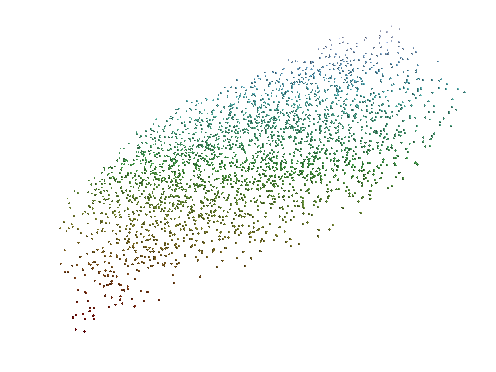

In [39]:
mayavi_plt_pts(planar_test_res, focus=focus, dist=dist)

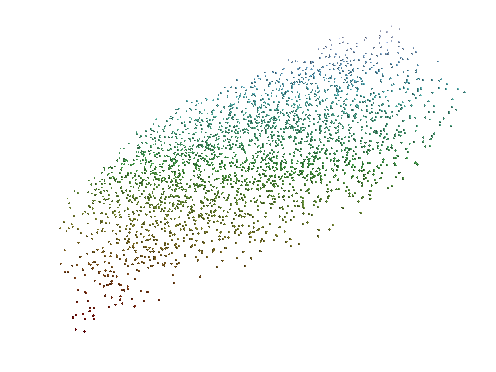

In [40]:
mayavi_plt_pts(test_res[0], focus=focus, dist=dist)

(array([1.324e+03, 9.440e+02, 3.870e+02, 1.160e+02, 1.730e+02, 4.200e+01,
        4.000e+00, 1.000e+00, 1.000e+00, 8.000e+00]),
 array([0.00000000e+00, 7.93791286e-31, 1.58758257e-30, 2.38137386e-30,
        3.17516514e-30, 3.96895643e-30, 4.76274772e-30, 5.55653900e-30,
        6.35033029e-30, 7.14412157e-30, 7.93791286e-30]),
 <a list of 10 Patch objects>)

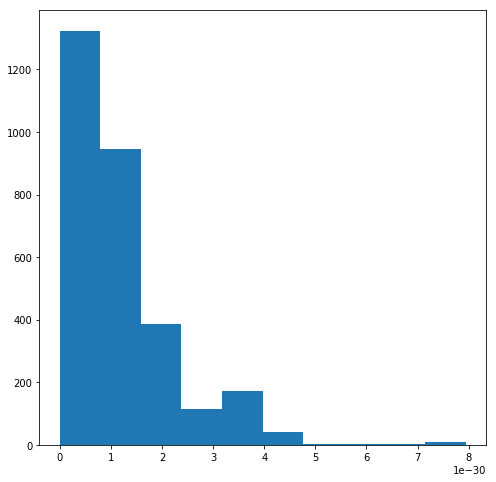

In [41]:
plt.hist(np.sum((planar_test_res-test_res[0])**2, axis=1))

In [42]:
weird = np.argmax(p2d)
print(x[weird], p1p[weird], p2p[weird])
print(
    np.concatenate([x[weird], [1]]).reshape(1,-1)@q_test@np.concatenate([x[weird], [1]]).reshape(-1,1),
    np.concatenate([p1p[weird], [1]]).reshape(1,-1)@q_test@np.concatenate([p1p[weird], [1]]).reshape(-1,1),
    np.concatenate([p2p[weird], [1]]).reshape(1,-1)@q_test@np.concatenate([p2p[weird], [1]]).reshape(-1,1)
)

[ 2.32905281 -0.95242292  2.47628845] [2.8649511 0.9363881 1.5431113] [2.8613412 0.9236089 1.5494356]
[[-4.1385424]] [[0.03360237]] [[3.15884391e-06]]


In [43]:
E = np.block([[u, x[weird].reshape(-1,1)],[np.zeros(3), 1]])
np.round(E.T@q_test@E,5)

array([[ 0.5    ,  0.     ,  0.     , -0.01202],
       [ 0.     ,  0.25   , -0.     , -0.34985],
       [ 0.     ,  0.     ,  0.1    , -0.72606],
       [-0.01202, -0.34985, -0.72606, -4.13854]])

In [44]:
tp1p, tp1d = orthogonal_quadric_projection(x,q_test,projection_funcs)
tp2p, tp2d = orthogonal_quadric_projection(tp1p,q_test,projection_funcs)

In [45]:
print(x[weird], tp1p[weird], tp2p[weird])

[ 2.32905281 -0.95242292  2.47628845] [2.85314187 0.91533736 1.52832908] [2.85314187 0.91533736 1.52832908]


In [46]:
print(np.sum(p1p, axis=0))

[ 2593.417  -2856.5596  5061.0103]


[5.39088516e-14 1.27417658e-11 3.63746572e-13 ... 1.17607834e-12
 3.68558436e-12 1.30174983e-13]


(array([2.997e+03, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([3.34973948e-16, 3.04689860e+01, 6.09379721e+01, 9.14069581e+01,
        1.21875944e+02, 1.52344930e+02, 1.82813916e+02, 2.13282902e+02,
        2.43751888e+02, 2.74220874e+02, 3.04689860e+02]),
 <a list of 10 Patch objects>)

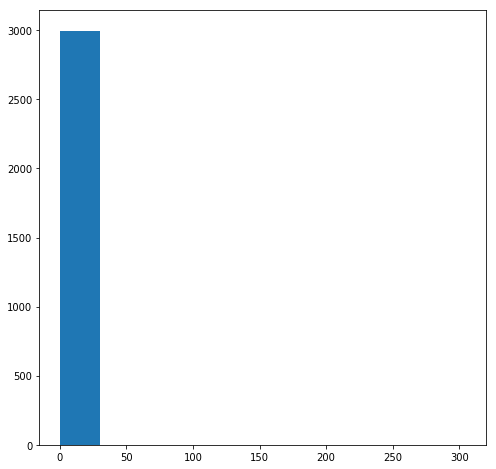

In [47]:
print(np.sum((p1p-tp1p)**2, axis=1))
plt.hist(np.sum((p1p-tp1p)**2, axis=1))

In [48]:
# test quadric_ortho_projection
with tf.Graph().as_default(), tf.Session() as sess:
    test_qs = tf.placeholder(tf.float32, q.shape)
    test_pts = tf.placeholder(tf.float32, x.shape)
    test_qsc = tf.cast(test_qs, tf.complex128 if test_qs.dtype == tf.float64 else tf.complex64)
    test_ptsc = tf.cast(test_pts, tf.complex128 if test_pts.dtype == tf.float64 else tf.complex64)
    L,U,UL,UR,BR = tf_rotate_and_translate_quadric(test_qs,test_pts)
    ARGS, roots = tf_ortho_project_x(UL,UR,BR)
    res = sess.run([ARGS,roots], feed_dict={test_pts: x, test_qs: q_test})

Q Tensor("Placeholder:0", shape=(4, 4), dtype=float32)
Tensor("transpose:0", shape=(3, 3), dtype=float32)
Tensor("matmul_1:0", shape=(3000, 3), dtype=float32)
Tensor("matmul_2:0", shape=(1, 3), dtype=float32)
L,U,UL,UR,BR Tensor("SelfAdjointEigV2:0", shape=(3,), dtype=float32) Tensor("SelfAdjointEigV2:1", shape=(3, 3), dtype=float32) Tensor("SelfAdjointEigV2:0", shape=(3,), dtype=float32) Tensor("add:0", shape=(3000, 3), dtype=float32) Tensor("add_2:0", shape=(3000, 1), dtype=float32)
args0 Tensor("strided_slice_5:0", shape=(3000, 1), dtype=float32)
(3000, 1)
args1 Tensor("strided_slice_6:0", shape=(3000, 1), dtype=float32)
(3000, 1)
args2 Tensor("strided_slice_7:0", shape=(3000, 1), dtype=float32)
(3000, 1)
args3 Tensor("strided_slice_8:0", shape=(3000, 1), dtype=float32)
(3000, 1)
args4 Tensor("strided_slice_9:0", shape=(3000, 1), dtype=float32)
(3000, 1)
args5 Tensor("strided_slice_10:0", shape=(3000, 1), dtype=float32)
(3000, 1)
args6 Tensor("strided_slice_11:0", shape=(3000, 1), d

In [49]:
def nptriu(x):
    dim = tf.cast((tf.sqrt(1+8*tf.cast(x.shape[0],tf.float32))-1)/2, tf.int32)
    def nptriu_help(i):
        return tf.concat((tf.zeros(i,dtype=x.dtype), x[i*(dim+1) - tf.div(i*(i+1),2):(i+1)*(dim+1) - tf.div((i+1)*(i+2),2)]), axis=-1)
    return tf.map_fn(nptriu_help, tf.range(dim), dtype=x.dtype)

In [50]:
def nptriu_inv_indices(x):
    dim = x.get_shape().as_list()[0]
    n_indices = tf.div(dim*(dim+1),2)
    indices = tf.range(n_indices)
    pair_indices_1 = tf.cast(dim - tf.sqrt(tf.cast(4*dim*dim + 4*dim - 8*indices + 1, tf.float32))/2 + 1/2, tf.int32)
    pair_indices_2 = pair_indices_1 + indices - (n_indices - tf.div((dim-pair_indices_1)*(dim-pair_indices_1+1),2))
    return tf.stack((pair_indices_1, pair_indices_2), axis=-1)

In [51]:
with tf.Graph().as_default(), tf.Session() as sess:
    triu_test = sess.run(nptriu(tf.constant([1,2,3,4,5,6,7,8.,9,10])))
triu_test

array([[ 1.,  2.,  3.,  4.],
       [ 0.,  5.,  6.,  7.],
       [ 0.,  0.,  8.,  9.],
       [ 0.,  0.,  0., 10.]], dtype=float32)

In [52]:
with tf.Graph().as_default(), tf.Session() as sess:
    triu_inv_test = sess.run(nptriu_inv_indices(tf.constant(triu_test)))
triu_inv_test

array([[0, 0],
       [0, 1],
       [0, 2],
       [0, 3],
       [1, 1],
       [1, 2],
       [1, 3],
       [2, 2],
       [2, 3],
       [3, 3]], dtype=int32)

In [53]:
def unit_norm_constraint(fq):
    return fq/tf.norm(fq)
    #return tf.concat((fq[:-1],[1.]), axis=-1)

In [54]:
def parabolic_constraint(fq, unit_norm=True):
    with tf.name_scope("parabolic_constraint"):
        upper_q = nptriu(fq)
        lower_q = tf.transpose(upper_q)
        q = upper_q + lower_q - tf.diag(tf.diag_part(upper_q))
        l,u = tf.linalg.eigh(lower_q[:-1,:-1])
        e = tf.concat(
            (
                tf.concat((u, tf.zeros((3,1), u.dtype)), axis=-1),
                tf.concat((tf.zeros((1,3),u.dtype), tf.ones((1,1),u.dtype)), axis=-1)
            ),
            axis=0)
        e_T = tf.transpose(e)
        q_rot = e_T@q@e
        eig_sorter = tf.argsort(tf.abs(l),axis=-1,direction='DESCENDING')
        eig_unsorter = tf.gather(tf.range(eig_sorter.shape[0]), eig_sorter)
        sorted_eigs = tf.gather(l, eig_sorter)
        print(sorted_eigs)
        constrained_sorted_eigs = tf.concat((sorted_eigs[:-1],[0]), axis=0)
        print(constrained_sorted_eigs)
        constrained_eigs = tf.gather(constrained_sorted_eigs, eig_unsorter)
        constrained_q_rot = tf.concat(
            (tf.concat((tf.diag(constrained_eigs), q_rot[:-1,-1:]), axis=-1),
            q_rot[-1:,:]), axis=0)
        print(constrained_q_rot.shape)
        constrained_q = e@constrained_q_rot@e_T
        if unit_norm:
            constrained_q = constrained_q / tf.norm(constrained_q)
        constrained_fq = tf.gather_nd(constrained_q, nptriu_inv_indices(constrained_q))
        return constrained_fq 

In [55]:
np.array([[1,0,0,4],[0,2,0,5],[0,0,3,6],[4,5,6,7]])[np.triu_indices(4)]

array([1, 0, 0, 4, 2, 0, 5, 3, 6, 7])

In [56]:
#test parabolic constraint
with tf.Graph().as_default(), tf.Session() as sess:
    parabolic_constraint_test = sess.run(
        parabolic_constraint(
            tf.constant(
                np.array([[1,0,0,4],[0,2,0,5],[0,0,3,6],[4,5,6,7]])[np.triu_indices(4)], 
                dtype=tf.float32),
            unit_norm=True,
        ))
print(parabolic_constraint_test)
assert np.allclose(parabolic_constraint_test, np.array([0.        , 0.        , 0.        , 0.27216554, 0.13608277,
   0.        , 0.34020692, 0.20412414, 0.40824828, 0.47628966]))

Tensor("parabolic_constraint/GatherV2_1:0", shape=(3,), dtype=float32)
Tensor("parabolic_constraint/concat_3:0", shape=(3,), dtype=float32)
(4, 4)
[0.         0.         0.         0.27216554 0.13608277 0.
 0.34020692 0.20412414 0.40824828 0.47628966]


In [57]:
parabolic_q = np.array([[1,0,0,4],[0,-1e-10,0,5],[0,0,3,6],[4,5,6,7]])
parabolic_q[:3,:3] = u@parabolic_q[:3,:3]@u.T
parabolic_q = parabolic_q / np.linalg.norm(parabolic_q)
parabolic_q, np.linalg.norm(parabolic_q)

(array([[ 0.04069459, -0.05709906,  0.0506639 ,  0.27407548],
        [-0.05709906,  0.1573033 , -0.03940756,  0.34259435],
        [ 0.0506639 , -0.03940756,  0.07607759,  0.41111323],
        [ 0.27407548,  0.34259435,  0.41111323,  0.4796321 ]]), 1.0)

In [58]:
with tf.Graph().as_default(), tf.Session() as sess:
    parabolic_constraint_test = sess.run(
        parabolic_constraint(
            tf.constant(
                parabolic_q[np.triu_indices(4)], 
                dtype=tf.float32),
            unit_norm=True,
        ))
print(parabolic_constraint_test)
assert np.allclose(parabolic_constraint_test, parabolic_q[np.triu_indices(4)])

Tensor("parabolic_constraint/GatherV2_1:0", shape=(3,), dtype=float32)
Tensor("parabolic_constraint/concat_3:0", shape=(3,), dtype=float32)
(4, 4)
[ 0.04069461 -0.05709909  0.0506639   0.27407545  0.1573034  -0.03940758
  0.34259436  0.07607758  0.4111132   0.47963223]


In [59]:
def design_x(x):
    return np.concatenate((x,np.ones(list(x.shape[:-1])+[1])),axis=-1)

In [60]:
def composed_constraint(*args):
    if len(args) == 1:
        return args[0]
    def f(the_input):
        return args[0](composed_constraint(*args[1:])(the_input))
    return f

In [61]:
def square(x):
    return x**2
composed_constraint(square,square,square)(2)

256

In [62]:
class fuckit(object):
    def __init__(self, message=None):
        self.message = message
    def __enter__(self): return self
    def __exit__(self, *args):
        if self.message is not None:
            print(self.message)
        return True

In [110]:
import ml_battery
import tensorflow_probability as tfp
import tf_roots.src.companion_eigv


class TFQuadric(sklearn.base.BaseEstimator, ml_battery.tensorflow_models.PickleableTFModel):
    ''' A zero hidden layer NN Classifier (i.e. Logit Regression).
        Parameters:
            n_epochs: number of training epochs
            learning_rate: make it bigger to learn faster, at the risk of killing your relu
            trainable: set to false if you want to not allow training.  For example, if you want to use this as part of another network
            batch_size: defaults to the entire dataset.
    '''
    def __init__(self, n_epochs=300, learning_rate=0.05, trainable=True, batch_size=None, 
        log_epochs=False, model=None, weighted=True, input_shape=3, parabolic_constraint=False):
        global TFQuadricGraph
        global TFQuadricSesh
        try:
            TFQuadricGraph
        except:
            TFQuadricGraph = tf.Graph()
        try:
            TFQuadricSesh
        except:
            TFQuadricSesh = tf.Session(graph = TFQuadricGraph)
        self.sess = TFQuadricSesh
        self.graph = TFQuadricGraph
        self.n_epochs = n_epochs
        self.learning_rate = learning_rate
        self.trainable = trainable
        self.batch_size = batch_size
        self.log_epochs = log_epochs
        self.model = model
        self.input_shape_ = input_shape
        self.weighted = weighted
        #self.init_q = np.zeros((9,))
        self.init_q = np.zeros((10,))
        self.parabolic_constraint = parabolic_constraint
        if self.model is None:
            print("building!")
            self.build_model()
        
        super().__init__()

    def fit(self, X, y=None, sample_weight=None, beta0=None,**fit_params):
        ''' Puts inputs into np format, initializes a session, builds the graph and then calls `.fit_` which can be overridden by individual models '''

        X = sklearn.utils.check_array(X)
        self.init_vars_(X,y,sample_weight,beta0)
    
        with self.graph.as_default():
            #self.blah = self.sess.run(self.model.blah, feed_dict={self.model.x:X})
            fitted_model = self.fit_(X, sample_weight=sample_weight, **fit_params)
            self.coef_ = self.sess.run(self.model.fq)
            self.intercept_ = np.array([])
        
        return fitted_model

    def init_vars_(self, X, y=None, sample_weight=None, beta0=None):
        if beta0 is None:
            beta0 = self.fast_reasonable_q(X,sample_weight)
 
        #beta0 /= beta0[-1] #TODO If the point lies ON the quadric, the remaining variables go to inf!!!! This is probably a problem for the iterated method
        #self.init_q = beta0[:-1] 
        self.init_q = beta0#/np.linalg.norm(beta0)
        print(self.init_q.shape)
    
        with self.graph.as_default():
            self.sess.run(self.model.initializer)
            self.sess.run(self.model.fq_feed, feed_dict={self.model.fq_placeholder: self.init_q})

    def predict(self, X, return_dists=False):
        X = sklearn.utils.check_array(X)

        with self.graph.as_default():
            print(self.sess.run(self.model.fq))
            self.sess.run(self.model.fq_feed, feed_dict={self.model.fq_placeholder: self.coef_})
            print(self.sess.run(self.model.fq))
            projections, dists = self.sess.run((self.model.orthogonal_projections, self.model.dists), feed_dict={self.model.x:X})
                
        if return_dists:
            return projections, dists
        return projections

    def build_model(self):
        ''' Initializes a new graph, and then calls the .build_model_ method, which must be implemented by a TFEstimator '''
        self.model = ml_battery.tensorflow_models.NameSpace()
        with self.graph.as_default():
            self.build_model_()
            
    def build_model_(self):
        ''' The actual network architecture '''
        with tf.name_scope("quadric_regression"):

            with tf.name_scope("input"):
                input_dim = [None, self.input_shape_]
                self.model.x = tf.placeholder(tf.complex128, shape=input_dim, name="input")
                #self.model.init_q = tf.placeholder(tf.float32, shape=int((self.input_shape_ + 2)*(self.input_shape_ + 1)/2 - 1), name="initial_quadric")
                if self.weighted:
                    self.model.sample_weight = tf.placeholder(tf.float64, shape=[None], name="sample_weight")

            with tf.name_scope("quadric_projection"):
                if self.parabolic_constraint:
                    self.model.fq = tf.Variable(self.init_q, name="flattened_quadric", trainable=self.trainable, 
                        constraint=parabolic_constraint)
                else:
                    self.model.fq = tf.Variable(self.init_q, name="flattened_quadric", trainable=self.trainable,
                        constraint=unit_norm_constraint)
                print(self.model.fq)
                self.model.fq_placeholder = tf.placeholder(tf.float64, shape=self.init_q.shape)
                self.model.fq_feed = self.model.fq.assign(self.model.fq_placeholder)
                q = nptriu(self.model.fq)
                #TODO: I removed a /2 here and shit fell apart
                self.model.q = q + tf.transpose(q) - tf.diag(tf.diag_part(q))
                print(self.model.q)
                if not self.model.q.dtype.is_complex:
                    self.model.qc = tf.cast(self.model.q, tf.complex128 if self.model.q.dtype == tf.float64 else tf.complex64)
                else:
                    self.model.qc = self.model.q
                print(self.model.qc)
                self.model.orthogonal_projections, self.model.complex_dists = tf_ortho_project(
                    self.model.qc, self.model.x, imag_0tol=np.inf)
                print(self.model.orthogonal_projections)
                print(self.model.complex_dists)
                self.model.dists = tf.real(self.model.complex_dists)
      
            if self.trainable:
                with tf.name_scope("training"):
                    if not self.weighted:
                        self.model.loss = tf.reduce_sum(self.model.dists, name="loss")
                    else:
                        self.model.loss = tf.reduce_sum(self.model.dists*self.model.sample_weight, name="loss")
                    #self.model.loss = tf.log(self.model.loss) #TODO: this is kinda jank.
                    
                    self.model.optimizer = tf.train.AdamOptimizer(self.learning_rate, name="optimizer")
                    self.model.grads = self.model.optimizer.compute_gradients(self.model.loss)
                    self.model.grad_application = self.model.optimizer.apply_gradients(self.model.grads)
                    with tf.control_dependencies([self.model.grad_application]):
                        self.model.train_step = tf.no_op(name="train_step")

            self.model.initializer = tf.global_variables_initializer()

        return self.model     

    def fast_reasonable_q(self, X, sample_weight=None):
        #this allows us to orient the data to set an initial set of parameters
        global_linear_model = local_models.TLS_models.LinearODR_mD(2)
        global_linear_model.fit(X, sample_weight=sample_weight)
        global_linear_vecs = global_linear_model.cov_eigenvectors[global_linear_model.cov_eigenvalues_sorter]
        global_linear_std = global_linear_model.cov_eigenvalues[global_linear_model.cov_eigenvalues_sorter]
        global_linear_mean = global_linear_model.intercept_
        print(global_linear_std)

        transformed_X = (X-global_linear_mean)@global_linear_vecs.T

        transformed_q = np.zeros((4,4))

        if False:
            # initialize to the best elliptic paraboloid
            transformed_q[np.diag_indices(3)] = 1/global_linear_model.cov_eigenvalues[global_linear_model.cov_eigenvalues_sorter]**2
            transformed_q[:3,-1] = transformed_q[-1,:3] = 1/global_linear_model.cov_eigenvalues[global_linear_model.cov_eigenvalues_sorter]
            transformed_q[3,3] = np.sum(global_linear_mean)
            transformed_q[2,2] = 0
        if self.parabolic_constraint:
            # initialize to the best plane
            transformed_q[3,:3] = transformed_q[:3,3] = global_linear_vecs[-1]
            transformed_q[3,3] = np.dot(global_linear_vecs[-1], -global_linear_mean)
            
            #test stuff
            transformed_q[np.diag_indices(3)] = 0.0001
            transformed_q[0,0] = 0

            print(transformed_q)
            #transformed_q[:3,:3] = np.array([[0,1,1],[0,0,4],[0,0,3]])
            #transformed_q[:3,:3] = np.array([[0,1,1],[0,1,4],[0,0,3]])
        else:
            # an ellipse with axes in the various directions
            transformed_q[np.diag_indices(3)] = 1/global_linear_std
            # shift so that the ellipse hits the origin at the fitted plane.  TODO: do we want the ellipse to open up or down??
            #transformed_q[:3,-1] = transformed_q[-1,:3] = -2*np.sqrt(global_linear_std)
            transformed_q[2,-1] = transformed_q[-1,2] = -2/np.sqrt(global_linear_std[2])
            #transformed_q[3,3] = np.sum(
            #    transformed_q[np.diag_indices(3)],
            #    global_linear_mean**2
            #)
            transformed_q[3,3] = -1
        
        print(transformed_q)
        E = np.block([[global_linear_vecs, global_linear_mean.reshape(-1,1)],[np.zeros(3),1]])
        Einv = np.linalg.inv(E)
        q = Einv.T@transformed_q@Einv
        q = q / np.linalg.norm(q)
        print(q)
        beta0 = q[np.triu_indices(4)]
        print(beta0.shape)
        return beta0

    def fit_(self, X, sample_weight=None, feed_dict_extras={}):
        ''' Trains for a number of epochs.  Model input must be in self.model.x, output in self.model.y, loss in self.model.loss, and training using self.model.train_step '''

        logger.info("fitting quadric model")


        self.fitted_qs = []
        for epoch in range(self.n_epochs):
            print(epoch)
            batcher = ml_battery.tensorflow_models.np_batcher(X.shape[0], self.batch_size)

            for batch in batcher:
            
                fitted_q = np.zeros((4,4))
                fitted_q[np.triu_indices(4)] = self.sess.run(self.model.fq)
                fitted_q = fitted_q.T
                self.fitted_qs.append(fitted_q)
            
                feed_dict={
                    self.model.x : X[batch]
                }
                if self.weighted:
                    feed_dict[self.model.sample_weight] = sample_weight[batch]
                feed_dict.update(feed_dict_extras)
                
                loss, grads, _ = self.sess.run(
                    (self.model.loss, self.model.grads, self.model.train_step),
                    feed_dict
                )
                
                log_str = "epoch: {:06d} ::: loss: {:08.02f} ::: grad {}"
                if self.log_epochs: logger.info(log_str.format(epoch, loss.sum(), 
                    ["{:06.02f}".format(grad) for grad in grads[0][0]]))
                
        logger.info("finished fitting :::: loss: " + str(loss.sum()))
        self.final_loss = loss.sum()

        return self

In [111]:
with fuckit("nothing to del"):
    del TFQuadricSesh; del TFQuadricGraph

nothing to del


In [112]:
with fuckit("they don't exist"): 
    print(TFQuadricSesh.graph, TFQuadricGraph, len(TFQuadricSesh.graph.get_operations()))

they don't exist


In [113]:
with fuckit("no sess to close"): 
    tfmodel.sess.close()

no sess to close


In [96]:
tfmodel = TFQuadric(n_epochs=5000, log_epochs=True, weighted=False, parabolic_constraint=True, learning_rate=0.01)

building!
<tf.Variable 'quadric_regression/quadric_projection/flattened_quadric:0' shape=(10,) dtype=float64_ref>
Tensor("quadric_regression/quadric_projection/sub_1:0", shape=(4, 4), dtype=float64)
Tensor("quadric_regression/quadric_projection/Cast_2:0", shape=(4, 4), dtype=complex128)
Q Tensor("quadric_regression/quadric_projection/Cast_2:0", shape=(4, 4), dtype=complex128)
Tensor("quadric_regression/quadric_projection/transpose_1:0", shape=(3, 3), dtype=complex128)
Tensor("quadric_regression/quadric_projection/matmul_1:0", shape=(?, 3), dtype=complex128)
Tensor("quadric_regression/quadric_projection/matmul_2:0", shape=(1, 3), dtype=complex128)
L,U,UL,UR,BR Tensor("quadric_regression/quadric_projection/SelfAdjointEigV2:0", shape=(3,), dtype=complex128) Tensor("quadric_regression/quadric_projection/SelfAdjointEigV2:1", shape=(3, 3), dtype=complex128) Tensor("quadric_regression/quadric_projection/SelfAdjointEigV2:0", shape=(3,), dtype=complex128) Tensor("quadric_regression/quadric_proj

In [97]:
qq = [[ 0.          ,0.          ,0.           ,3.53204353],
      [ 0.          ,0.          ,0.           ,4.27931222],
      [ 0.          ,0.          ,0.           ,-1.70128533],
      [ 3.53204353  ,4.27931222  ,-1.70128533  ,3.12202898]]
qq = np.array(qq)

In [82]:
a,b,c,d,e,f,g = list(qq[np.diag_indices(4)]) + list(qq[-1,:3])

In [83]:
blah = projection_funcs["k_mat"](a,b,c,d,e,f,g)
blah

[0.0, 0.0, 0.0, 0.0, 0.0, 2968.3068801324443, 485.89353352102574]

In [84]:
np.roots(blah)

array([-0.16369383])

In [85]:
tfmodel.init_vars_(p1p)

[4.24163087 3.44317333 1.20205112]
[[ 0.2         0.          0.          0.        ]
 [ 0.          0.05        0.          0.        ]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          1.         -1.59928918]]
[[ 0.2         0.          0.          0.        ]
 [ 0.          0.05        0.          0.        ]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          1.         -1.59928918]]
[[ 0.05895022  0.00519392 -0.02093172 -0.12402803]
 [ 0.00519392  0.014437    0.00445309  0.13106101]
 [-0.02093172  0.00445309  0.01026908 -0.28205819]
 [-0.12402803  0.13106101 -0.28205819  0.87807037]]
(10,)
(10,)


In [447]:
blah = np.array(
[[ 0.08625544,  0.01496537, -0.03100936, -0.37957495],
 [ 0.01496537,  0.08370539,  0.03376366,  0.41248621],
 [-0.03100936,  0.03376366,  0.03003917, -0.8282516 ],
 [-0.37957495,  0.41248621, -0.8282516 ,  2.6482076 ]]
 )
print(np.linalg.eig(blah[:-1,:-1]))

(array([6.70906246e-10, 9.99999947e-02, 1.00000005e-01]), array([[ 0.37073652,  0.87117659, -0.32187853],
       [-0.40366587, -0.16097854, -0.90063298],
       [ 0.83642591, -0.46382891, -0.29198363]]))


In [448]:
#x = (np.random.uniform(size=(3000,3))-0.5)*10
tfmodel.fit(p1p)

[4.97395306 3.90845057 1.05297347]
[[ 0.2         0.          0.          0.        ]
 [ 0.          0.05        0.          0.        ]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          1.         -1.48386085]]
[[ 0.2         0.          0.          0.        ]
 [ 0.          0.05        0.          0.        ]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          1.         -1.48386085]]
[[ 0.05562681  0.00384636 -0.02283621 -0.12103442]
 [ 0.00384636  0.01235738  0.00608147  0.16322218]
 [-0.02283621  0.00608147  0.01422814 -0.25857902]
 [-0.12103442  0.16322218 -0.25857902  0.88266422]]
(10,)
(10,)
0


InvalidArgumentError: Self-adjoint eigen decomposition was not successful. The input might not be valid.
	 [[node quadric_regression/training/optimizer/update_quadric_regression/quadric_projection/flattened_quadric/parabolic_constraint/SelfAdjointEigV2 (defined at <ipython-input-364-76365cb58087>:6) ]]

Original stack trace for 'quadric_regression/training/optimizer/update_quadric_regression/quadric_projection/flattened_quadric/parabolic_constraint/SelfAdjointEigV2':
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.5/dist-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.5/asyncio/base_events.py", line 345, in run_forever
    self._run_once()
  File "/usr/lib/python3.5/asyncio/base_events.py", line 1312, in _run_once
    handle._run()
  File "/usr/lib/python3.5/asyncio/events.py", line 125, in _run
    self._callback(*self._args)
  File "/usr/local/lib/python3.5/dist-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/usr/local/lib/python3.5/dist-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/usr/local/lib/python3.5/dist-packages/tornado/gen.py", line 781, in inner
    self.run()
  File "/usr/local/lib/python3.5/dist-packages/tornado/gen.py", line 742, in run
    yielded = self.gen.send(value)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 378, in dispatch_queue
    yield self.process_one()
  File "/usr/local/lib/python3.5/dist-packages/tornado/gen.py", line 225, in wrapper
    runner = Runner(result, future, yielded)
  File "/usr/local/lib/python3.5/dist-packages/tornado/gen.py", line 708, in __init__
    self.run()
  File "/usr/local/lib/python3.5/dist-packages/tornado/gen.py", line 742, in run
    yielded = self.gen.send(value)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/usr/local/lib/python3.5/dist-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/usr/local/lib/python3.5/dist-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/usr/local/lib/python3.5/dist-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2848, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2874, in _run_cell
    return runner(coro)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 3049, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 3214, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-441-cd3eb8df8485>", line 1, in <module>
    tfmodel = TFQuadric(n_epochs=5000, log_epochs=True, weighted=False, parabolic_constraint=True, learning_rate=0.01)
  File "<ipython-input-437-c7966ec86af2>", line 41, in __init__
    self.build_model()
  File "<ipython-input-437-c7966ec86af2>", line 89, in build_model
    self.build_model_()
  File "<ipython-input-437-c7966ec86af2>", line 137, in build_model_
    self.model.grad_application = self.model.optimizer.apply_gradients(self.model.grads)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/training/optimizer.py", line 614, in apply_gradients
    update_ops.append(processor.update_op(self, grad))
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/training/optimizer.py", line 122, in update_op
    return self._v.assign(self._v.constraint(self._v))
  File "<ipython-input-364-76365cb58087>", line 6, in parabolic_constraint
    l,u = tf.linalg.eigh(lower_q[:-1,:-1])
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/linalg_ops.py", line 328, in self_adjoint_eig
    e, v = gen_linalg_ops.self_adjoint_eig_v2(tensor, compute_v=True, name=name)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gen_linalg_ops.py", line 2168, in self_adjoint_eig_v2
    "SelfAdjointEigV2", input=input, compute_v=compute_v, name=name)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 3616, in create_op
    op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 2005, in __init__
    self._traceback = tf_stack.extract_stack()


In [449]:
tfmodel.coef_.shape

AttributeError: 'TFQuadric' object has no attribute 'coef_'

In [93]:
fitted_q = np.zeros((4,4)); fitted_q[np.triu_indices(4)]=np.copy(tfmodel.init_q)
#fitted_q = np.copy(tfmodel.fitted_qs[-1])
#fitted_q = np.zeros((4,4)); fitted_q[np.triu_indices(4)]=np.copy(tfmodel.coef_)
fitted_q += fitted_q.T
fitted_q[np.diag_indices(4)] /= 2
print(np.linalg.norm(fitted_q))
print(np.round(fitted_q,3))
fitted_q_u = np.linalg.eigh(fitted_q[:3,:3])[1]
fitted_q_e = np.zeros((4,4))
fitted_q_e[3,3] = 1
fitted_q_e[:3,:3] = fitted_q_u
fitted_q_rot = fitted_q_e.T@fitted_q@fitted_q_e
print(np.round(fitted_q_rot,3))
print(np.linalg.norm(fitted_q_rot))

0.9999999999999999
[[ 0.059  0.005 -0.021 -0.124]
 [ 0.005  0.014  0.004  0.131]
 [-0.021  0.004  0.01  -0.282]
 [-0.124  0.131 -0.282  0.878]]
[[ 0.    -0.     0.     0.335]
 [-0.     0.017 -0.     0.003]
 [ 0.    -0.     0.067  0.012]
 [ 0.335  0.003  0.012  0.878]]
0.9999999999999999


In [94]:
tfmodel.init_q

array([ 0.05895022,  0.00519392, -0.02093172, -0.12402803,  0.014437  ,
        0.00445309,  0.13106101,  0.01026908, -0.28205819,  0.87807037])

In [95]:
q_test/np.linalg.norm(q_test)

array([[ 0.07611025,  0.02807786,  0.01067586, -0.17447764],
       [ 0.02807786,  0.06859417,  0.04784969,  0.08580255],
       [ 0.01067586,  0.04784969,  0.11565392, -0.40420559],
       [-0.17447764,  0.08580255, -0.40420559,  0.75323901]])

In [96]:
data_avg = np.average(x, axis=0)
data_std = np.std(x, axis=0)

In [97]:
fitted_q_pts, fitted_q_dists = orthogonal_quadric_projection(x,fitted_q,projection_funcs)

In [98]:
np.sum(fitted_q_dists)

37462.03400534445

In [109]:
with tfmodel.graph.as_default():
    feed_dict={
        tfmodel.model.x : p1p,
    }
    '''
    blah = tfmodel.sess.run(
        (tfmodel.model.fq, tfmodel.model.q, tfmodel.model.loss),# tfmodel.model.loss, tfmodel.model.dists, tfmodel.model.complex_dists, tfmodel.model.orthogonal_projections),
        feed_dict
    )
    '''
    blah = tfmodel.sess.run(
        (tfmodel.model.fq, tfmodel.model.qc),
        feed_dict
    )   
    blah = tfmodel.sess.run(
        (tfmodel.model.fq, tfmodel.model.qc, tfmodel.model.loss, tfmodel.model.dists, tfmodel.model.complex_dists, tfmodel.model.orthogonal_projections),
        feed_dict
    )
    
    grads = tfmodel.sess.run(
        tf.gradients(tfmodel.model.loss, tfmodel.model.qc),
        feed_dict
    )
    
    for k,name in [
        ("dists", "quadric_regression/quadric_projection/Sum_2:0"), #dists
        ("kmat", "quadric_regression/quadric_projection/stack:0"), #kmat
        ("coeff_vectors", "quadric_regression/quadric_projection/strided_slice_12:0"), #coeff_vectors
        ("rotated_coeffs", "quadric_regression/quadric_projection/Gather/Reshape_3:0"), #rotated_coeffs
        ("backward_coeffs", "quadric_regression/quadric_projection/strided_slice_17:0"), #backward_coeffs
        ("scaled_backward_coeffs", "quadric_regression/quadric_projection/truediv_1:0"), #scaled_backward_coeffs
        ("roots", "quadric_regression/quadric_projection/CompanionEigv:0"), #roots
        ("L", "quadric_regression/quadric_projection/SelfAdjointEigV2:0"), #L
        ("U", "quadric_regression/quadric_projection/SelfAdjointEigV2:1"), #U
        ("UL", "quadric_regression/quadric_projection/SelfAdjointEigV2:0"), #UL
        ("UR", "quadric_regression/quadric_projection/add_2:0"), #UR
        ("BR", "quadric_regression/quadric_projection/add_4:0"), #BR
        ("k6", "quadric_regression/quadric_projection/mul_5:0"), #k6
        ("k5", "quadric_regression/quadric_projection/mul_14:0"), #k5
        ("k4", "quadric_regression/quadric_projection/add_24:0"), #k4
        ("k3", "quadric_regression/quadric_projection/mul_88:0"), #k3
        ("k2", "quadric_regression/quadric_projection/mul_106:0"), #k2
        ("k1", "quadric_regression/quadric_projection/mul_110:0"), #k1
        ("k0", "quadric_regression/quadric_projection/mul_111:0"), #k0
        ("a", "quadric_regression/quadric_projection/strided_slice_5:0"), #a0
        ("b", "quadric_regression/quadric_projection/strided_slice_6:0"), #a1
        ("c", "quadric_regression/quadric_projection/strided_slice_7:0"), #a2
        ("d", "quadric_regression/quadric_projection/strided_slice_8:0"), #a3
        ("e", "quadric_regression/quadric_projection/strided_slice_9:0"), #a4
        ("f", "quadric_regression/quadric_projection/strided_slice_10:0"), #a5
        ("g", "quadric_regression/quadric_projection/strided_slice_11:0"), #a6
        ("pts_nonan", "quadric_regression/quadric_projection/Select:0"), #pts_nonan
    ]:
        print(k, name)
        res = tfmodel.sess.run((
            tfmodel.graph.get_tensor_by_name(name),
            tf.gradients(tfmodel.model.loss, 
                tfmodel.graph.get_tensor_by_name(name))),
            feed_dict
        )
        if k=="dists": blah = res
        if k=="k1": badness_picker = res
        try:
            print("710", res[0][710], res[1][0][710])
            print("711", res[0][711], res[1][0][711])
        except:
            print(res)
        #print(np.sum(res[0]), np.sum(res[1]))
        #print(np.sum(res[0],axis=0))
print(grads)

dists quadric_regression/quadric_projection/Sum_2:0
710 [           inf 3.74629304e-04 9.15925568e+01 9.15925568e+01
 1.19646943e+03 1.19646943e+03] [0. 1. 0. 0. 0. 0.]
711 [           inf 7.58286644e-03 1.09663843e+02 1.09663843e+02
 1.19904606e+03 1.19904606e+03] [0. 1. 0. 0. 0. 0.]
kmat quadric_regression/quadric_projection/stack:0
710 [[ 1.14562880e-23+0.00000000e+00j -8.39118726e-07+0.00000000e+00j
  -4.24674572e-05+0.00000000e+00j -7.17848995e-04+0.00000000e+00j
  -4.58777653e-03+0.00000000e+00j -1.03153480e-02+3.78979737e-18j
  -1.79346512e-04+8.78544528e-20j]] [[ 0.00000000e+00+0.00000000e+00j  8.14293344e-09+1.57341632e-10j
  -3.97195928e-07+2.80587593e-19j  2.26676907e-05-1.20238346e-17j
  -1.29362907e-03+4.58536575e-16j  7.38264962e-02-1.31762389e-14j
  -4.21322592e+00+1.05075901e-14j]]
711 [[ 1.14562880e-23+0.00000000e+00j -8.39118726e-07+0.00000000e+00j
  -4.28779126e-05+0.00000000e+00j -7.38371765e-04+0.00000000e+00j
  -4.89475856e-03+0.00000000e+00j -1.17016041e-02+4.299

710 [0.06692505+0.j] [nan+nanj]
711 [0.06692505+0.j] [nan+nanj]
d quadric_regression/quadric_projection/strided_slice_8:0
710 [-0.01430402+0.j] [-0.05236472+2.39092695e-17j]
711 [0.06994572+0.j] [0.21728941+1.59490414e-16j]
e quadric_regression/quadric_projection/strided_slice_9:0
710 [-0.33462523+0.j] [nan+nanj]
711 [-0.33462523+0.j] [nan+nanj]
f quadric_regression/quadric_projection/strided_slice_10:0
710 [0.02494189+0.j] [nan+nanj]
711 [-0.03590272+0.j] [nan+nanj]
g quadric_regression/quadric_projection/strided_slice_11:0
710 [-0.15445954+0.j] [nan+nanj]
711 [0.22076549+0.j] [nan+nanj]
pts_nonan quadric_regression/quadric_projection/Select:0
710 [[            inf+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j]
 [-1.75225582e-02+3.08528470e-15j  1.30722059e-03-2.30370721e-16j
  -8.11667628e-03+1.43416997e-15j]
 [-5.26705917e+00-1.60552502e+00j  5.09191080e-01+2.17942419e-01j
   3.47131452e+00-6.99400707e+00j]
 [-5.26705917e+00+1.60552502e+00j  5.091

(array([2.898e+03, 5.500e+01, 3.600e+01, 4.000e+00, 2.000e+00, 2.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([2.49733102e-09, 4.94220775e+00, 9.88441549e+00, 1.48266232e+01,
        1.97688310e+01, 2.47110387e+01, 2.96532465e+01, 3.45954542e+01,
        3.95376619e+01, 4.44798697e+01, 4.94220774e+01]),
 <a list of 10 Patch objects>)

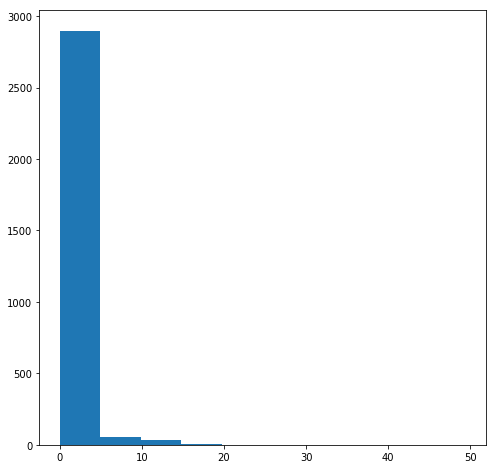

In [110]:
plt.hist(np.min(blah[0], axis=-1))

([array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.500e+01, 1.058e+03,
         1.106e+03, 7.530e+02, 5.700e+01, 1.000e+00]),
  array([1.000e+00, 0.000e+00, 0.000e+00, 2.400e+01, 5.760e+02, 1.066e+03,
         1.333e+03, 0.000e+00, 0.000e+00, 0.000e+00]),
  array([   0.,    0.,    0.,    0.,    0.,    0., 2139.,  777.,   81.,
            3.])],
 array([-15.072862  , -12.592108  , -10.111354  ,  -7.6305995 ,
         -5.149845  ,  -2.6690912 ,  -0.18833713,   2.292417  ,
          4.773171  ,   7.2539253 ,   9.734679  ], dtype=float32),
 <a list of 3 Lists of Patches objects>)

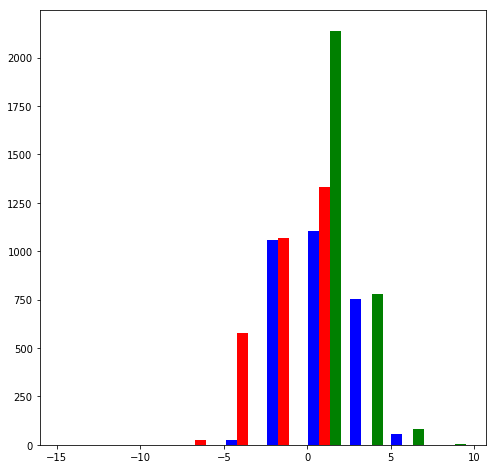

In [111]:
plt.hist(p1p,color=('b','r','g'))

1641 (522868.4926654487-8.348179831026841e-08j) (-0.03159982713402479+1.160958814598794e-17j)


(array([2.993e+03, 2.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 2.000e+00]),
 array([5.78334536e-07+1.71408126e-14j, 5.22868493e+04-8.34816440e-09j,
        1.04573699e+05-1.66963459e-08j, 1.56860548e+05-2.50445275e-08j,
        2.09147397e+05-3.33927090e-08j, 2.61434246e+05-4.17408906e-08j,
        3.13721096e+05-5.00890721e-08j, 3.66007945e+05-5.84372537e-08j,
        4.18294794e+05-6.67854352e-08j, 4.70581643e+05-7.51336168e-08j,
        5.22868493e+05-8.34817983e-08j]),
 <a list of 10 Patch objects>)

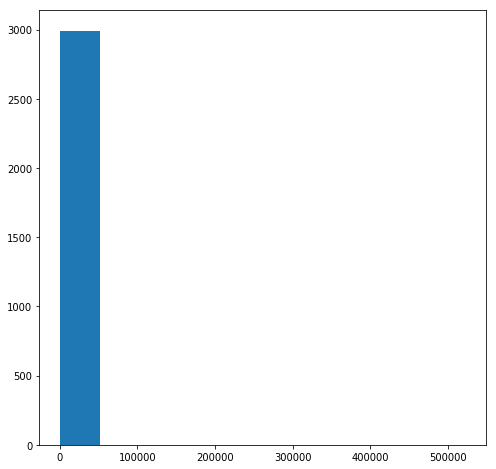

In [115]:
biggest = np.argmax(np.abs(badness_picker[1][0][:,0]))
print(biggest, badness_picker[1][0][biggest,0], badness_picker[0][biggest,0])
plt.hist(badness_picker[1][0][:,0])

In [116]:
I = biggest
print(p1p[I])
res[0][I]

[ 3.0515099 -0.597836   6.636405 ]


array([[         inf+0.00000000e+00j,   0.        +0.00000000e+00j,
          0.        +0.00000000e+00j],
       [ -4.39813499+1.28540083e-14j,   0.67527505-2.52990495e-15j,
          2.80310957-6.80582858e-14j],
       [ -5.49142717-5.90624634e-01j,   0.90120668+1.34202842e-01j,
         -1.98020335+1.91889558e+00j],
       [ -5.49142717+5.90624634e-01j,   0.90120668-1.34202842e-01j,
         -1.98020335-1.91889558e+00j],
       [-20.13419404-1.97655446e+00j,  -4.03354588+2.41275163e+01j,
         -0.50819812+1.62736727e-02j],
       [-20.13419404+1.97655446e+00j,  -4.03354588-2.41275163e+01j,
         -0.50819812-1.62736727e-02j]])

In [117]:
p1p[I:I+1]

array([[ 3.0515099, -0.597836 ,  6.636405 ]], dtype=float32)

In [121]:
# investigate explosive points
with tf.Graph().as_default(), tf.Session() as sess:
    test_qs = tf.placeholder(tf.float32, q.shape)
    test_pts = tf.placeholder(tf.float32, p1p.shape)
    test_qsc = tf.cast(test_qs, tf.complex128 if test_qs.dtype == tf.float64 else tf.complex64)
    test_ptsc = tf.cast(test_pts, tf.complex128 if test_pts.dtype == tf.float64 else tf.complex64)
    L,U,UL,UR,BR = tf_rotate_and_translate_quadric(test_qsc,test_ptsc)
    ARGS, roots = tf_ortho_project_x(UL,UR,BR)
    other_dims = tf_get_other_dims(UL,UR,BR)
    best = tf_min_dist_search_complex_constraint(other_dims, imag_0tol=np.inf)
    res = sess.run([ARGS,roots,other_dims, best], feed_dict={test_pts: p1p, test_qs: fitted_q})

Q Tensor("Cast:0", shape=(4, 4), dtype=complex64)
Tensor("transpose:0", shape=(3, 3), dtype=complex64)
Tensor("matmul_1:0", shape=(3000, 3), dtype=complex64)
Tensor("matmul_2:0", shape=(1, 3), dtype=complex64)
L,U,UL,UR,BR Tensor("SelfAdjointEigV2:0", shape=(3,), dtype=complex64) Tensor("SelfAdjointEigV2:1", shape=(3, 3), dtype=complex64) Tensor("SelfAdjointEigV2:0", shape=(3,), dtype=complex64) Tensor("add:0", shape=(3000, 3), dtype=complex64) Tensor("add_2:0", shape=(3000, 1), dtype=complex64)
args0 Tensor("strided_slice_5:0", shape=(3000, 1), dtype=complex64)
(3000, 1)
args1 Tensor("strided_slice_6:0", shape=(3000, 1), dtype=complex64)
(3000, 1)
args2 Tensor("strided_slice_7:0", shape=(3000, 1), dtype=complex64)
(3000, 1)
args3 Tensor("strided_slice_8:0", shape=(3000, 1), dtype=complex64)
(3000, 1)
args4 Tensor("strided_slice_9:0", shape=(3000, 1), dtype=complex64)
(3000, 1)
args5 Tensor("strided_slice_10:0", shape=(3000, 1), dtype=complex64)
(3000, 1)
args6 Tensor("strided_slice_11

In [123]:
res[3][0][I], res[3][1][I]

(array([ 4.3980794 -3.8181024e-06j, -0.67526394+7.5146721e-07j,
         2.8028145 -2.0212019e-05j], dtype=complex64), 27.654854)

(array([2.898e+03, 5.500e+01, 3.600e+01, 4.000e+00, 2.000e+00, 2.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([2.7966260e-08, 4.9422598e+00, 9.8845196e+00, 1.4826778e+01,
        1.9769039e+01, 2.4711298e+01, 2.9653557e+01, 3.4595818e+01,
        3.9538078e+01, 4.4480335e+01, 4.9422596e+01], dtype=float32),
 <a list of 10 Patch objects>)

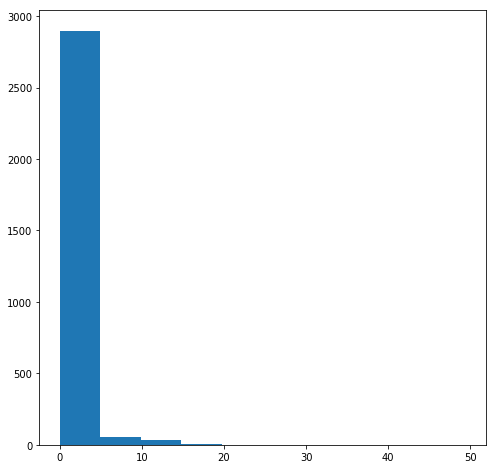

In [124]:
plt.hist(res[3][1])

In [125]:
# investigate explosive points
with tf.Graph().as_default(), tf.Session() as sess:
    test_qs = tf.placeholder(tf.float32, q.shape)
    test_pts = tf.placeholder(tf.float32, p1p.shape)
    test_qsc = tf.cast(test_qs, tf.complex128 if test_qs.dtype == tf.float64 else tf.complex64)
    test_ptsc = tf.cast(test_pts, tf.complex128 if test_pts.dtype == tf.float64 else tf.complex64)
    L,U,UL,UR,BR = tf_rotate_and_translate_quadric(test_qsc,test_ptsc)
    ARGS, roots = tf_ortho_project_x(UL,UR,BR)
    other_dims = tf_get_other_dims(UL,UR,BR)
    best = tf_min_dist_search_complex_constraint(other_dims, imag_0tol=np.inf)
    quad = tf_quadric_constraint(UL,UR,BR,tf.expand_dims(test_ptsc,-2))
    res = sess.run([quad,ARGS,roots,other_dims, best], feed_dict={test_pts: p1p, test_qs: q_test})

Q Tensor("Cast:0", shape=(4, 4), dtype=complex64)
Tensor("transpose:0", shape=(3, 3), dtype=complex64)
Tensor("matmul_1:0", shape=(3000, 3), dtype=complex64)
Tensor("matmul_2:0", shape=(1, 3), dtype=complex64)
L,U,UL,UR,BR Tensor("SelfAdjointEigV2:0", shape=(3,), dtype=complex64) Tensor("SelfAdjointEigV2:1", shape=(3, 3), dtype=complex64) Tensor("SelfAdjointEigV2:0", shape=(3,), dtype=complex64) Tensor("add:0", shape=(3000, 3), dtype=complex64) Tensor("add_2:0", shape=(3000, 1), dtype=complex64)
args0 Tensor("strided_slice_5:0", shape=(3000, 1), dtype=complex64)
(3000, 1)
args1 Tensor("strided_slice_6:0", shape=(3000, 1), dtype=complex64)
(3000, 1)
args2 Tensor("strided_slice_7:0", shape=(3000, 1), dtype=complex64)
(3000, 1)
args3 Tensor("strided_slice_8:0", shape=(3000, 1), dtype=complex64)
(3000, 1)
args4 Tensor("strided_slice_9:0", shape=(3000, 1), dtype=complex64)
(3000, 1)
args5 Tensor("strided_slice_10:0", shape=(3000, 1), dtype=complex64)
(3000, 1)
args6 Tensor("strided_slice_11

(array([1.445e+03, 1.195e+03, 2.580e+02, 6.600e+01, 2.800e+01, 5.000e+00,
        2.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([ -8.006784 +0.j,   2.8429625+0.j,  13.692709 +0.j,  24.542456 +0.j,
         35.392204 +0.j,  46.24195  +0.j,  57.091698 +0.j,  67.941444 +0.j,
         78.79119  +0.j,  89.64094  +0.j, 100.490685 +0.j], dtype=complex64),
 <a list of 10 Patch objects>)

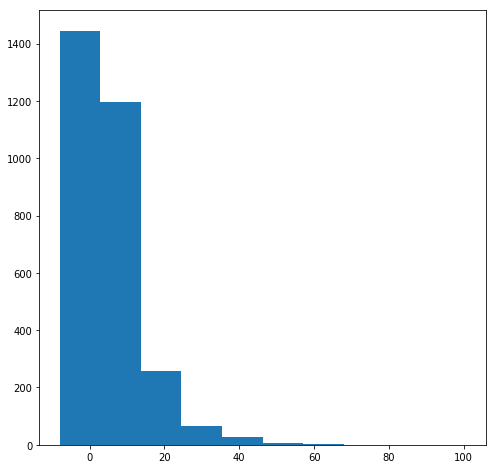

In [126]:
plt.hist(res[0][:,0])

In [127]:
res[0]

array([[ 2.8407028+0.j],
       [-0.6874465+0.j],
       [14.342502 +0.j],
       ...,
       [-1.1720297+0.j],
       [ 1.2081678+0.j],
       [ 7.1599007+0.j]], dtype=complex64)

In [ ]:
parents(tfmodel.graph.get_tensor_by_name("quadric_regression/quadric_projection/transpose_1:0").op).pop().outputs

In [ ]:
L_childs = [c for c in 
    children(tfmodel.graph.get_tensor_by_name("quadric_regression/quadric_projection/transpose_1:0").op)
    if not "gradkasdf" in c.name]
L_childs = sum([c.outputs for c in L_childs],[])
with tfmodel.graph.as_default():
    for c in L_childs:
        try:
            res = tfmodel.sess.run((c, tf.gradients(tfmodel.model.loss, c)), feed_dict)
            print(np.sum(res[0]), np.sum(res[1]))
            print(res, c)
        except:
            res = tfmodel.sess.run(c, feed_dict)
            print(res, c)

In [ ]:
L_childs = [c for c in 
    children(tfmodel.graph.get_tensor_by_name("quadric_regression/quadric_projection/MatMul:0").op)
    if not "grad" in c.name]
L_childs = sum([c.outputs for c in L_childs],[])
with tfmodel.graph.as_default():
    for c in L_childs:
        try:
            res2 = tfmodel.sess.run((c, tf.gradients(tfmodel.model.loss, c)), feed_dict)
            print(res2, c)
        except:
            print("training_gradient", tfmodel.sess.run(c, feed_dict), c)

In [385]:
with tf.Session() as sess:
    x = tf.constant(res2[0])
    

NameError: name 'res2' is not defined

In [386]:
set(op for out in c.op.outputs for op in out.consumers())

AttributeError: 'numpy.float64' object has no attribute 'op'

In [387]:
tfmodel.graph.get_operation_by_name("quadric_regression/quadric_projection/matmul_1").outputs[0]

<tf.Tensor 'quadric_regression/quadric_projection/matmul_1:0' shape=(?, 3) dtype=complex128>

In [388]:
blah[1], fitted_q

(array([0.01496537, 0.08370539, 0.03376366, 0.41248621]),
 array([[ 5.88504709e-02,  6.86657383e-04, -2.25500413e-02,
         -1.18156939e-01],
        [ 6.86657383e-04,  1.23877117e-02,  8.05267774e-03,
          1.79165064e-01],
        [-2.25500413e-02,  8.05267774e-03,  1.42265621e-02,
         -2.66425108e-01],
        [-1.18156939e-01,  1.79165064e-01, -2.66425108e-01,
          8.72322239e-01]]))

In [1705]:
blah[-1], fitted_q_pts

(array([[ 1.90997732, -1.22023821,  0.14552116],
        [ 1.72297668,  1.20254302,  3.90633082],
        [-0.43519258, -3.74397063,  1.29622626],
        ...,
        [ 3.58451033, -0.32773378,  0.5197947 ],
        [ 1.64555347,  0.8159107 ,  1.14921618],
        [ 1.29656506, -3.12960148,  0.32182455]]),
 array([[0.20672903, 0.96834895, 2.70781438],
        [1.43567446, 2.63096405, 1.96893774],
        [1.82682431, 2.86816377, 1.6142311 ],
        [2.00143001, 2.9291822 , 1.45127037]]))

In [1706]:
blah[4]

array([8.87708165e-31, 6.22592768e-32, 3.42259390e-31, ...,
       6.15375354e-32, 1.96935095e-33, 2.12986230e-31])

In [1707]:
print(fitted_q)

[[ 0.06167062 -0.01535048  0.03556619  0.00492948]
 [-0.01535048  0.07152435 -0.03094395  0.00252758]
 [ 0.03556619 -0.03094395  0.12600039  0.02080294]
 [ 0.00492948  0.00252758  0.02080294 -0.98456171]]


In [ ]:
with tf.Graph().as_default(), tf.Session() as sess:
    test_qs = tf.placeholder(tf.float32, q.shape)
    test_pts = tf.placeholder(tf.float32, x.shape)
    test_qsc = tf.cast(test_qs, tf.complex128 if test_qs.dtype == tf.float64 else tf.complex64)
    test_ptsc = tf.cast(test_pts, tf.complex128 if test_pts.dtype == tf.float64 else tf.complex64)
    sol_tf = tf_ortho_project(test_qsc, test_ptsc, imag_0tol=1e-3)
    res = sess.run(sol_tf, feed_dict={test_pts: p1p, test_qs: fitted_q})
test_res = orthogonal_quadric_projection(p1p, q_test,projection_funcs)
for i, r in enumerate(test_res):
    try:
        assert np.allclose(r, res[i], atol=1e-4, rtol=1e-4)
    except:
        print(r, res[i], np.abs(r-res[i]))

In [ ]:
q_test

In [ ]:
print(fitted_q)

In [ ]:
res[0]

In [ ]:
res[0]

In [ ]:
mayavi_plt_pts(res[0], display=True, focus=data_avg, dist=data_std, trim=False)

In [ ]:
mayavi_plt_pts([res[0],p1p], display=True, focus=data_avg, dist=data_std, trim=False)

In [ ]:
I = 2744

fitted_q = tfmodel.fitted_qs[I] + tfmodel.fitted_qs[I].T - np.diag(tfmodel.fitted_qs[I][np.diag_indices(4)])
fitted_q
fitted_q_u = np.linalg.eigh(fitted_q[:3,:3])[1]
fitted_q_e = np.zeros((4,4))
fitted_q_e[3,3] = 1
fitted_q_e[:3,:3] = fitted_q_u
fitted_q_rot = fitted_q_e.T@fitted_q@fitted_q_e
print(np.round(fitted_q,3))
print(np.round(fitted_q_rot,3))
print(np.linalg.norm(fitted_q_rot))

In [ ]:
with tf.Graph().as_default(), tf.Session() as sess:
    test_qs = tf.placeholder(tf.float32, q.shape)
    test_pts = tf.placeholder(tf.float32, x.shape)
    test_qsc = tf.cast(test_qs, tf.complex128 if test_qs.dtype == tf.float64 else tf.complex64)
    test_ptsc = tf.cast(test_pts, tf.complex128 if test_pts.dtype == tf.float64 else tf.complex64)
    projs,dists = tf_ortho_project(test_qsc, test_ptsc, imag_0tol=1e-3)
    loss = tf.reduce_sum(tf.abs(tf.real(dists)),axis=-1)
    res = sess.run((projs,dists,loss,tf.gradients(loss,test_qs)), feed_dict={test_pts: p1p, test_qs: fitted_q})
test_res = orthogonal_quadric_projection(p1p, fitted_q,projection_funcs)
print("total_loss: {} v {}".format(res[1].sum(), test_res[1].sum()))
for i, r in enumerate(test_res):
    try:
        assert np.allclose(r, res[i], atol=1e-4, rtol=1e-4)
    except:
        print(r, res[i], np.abs(r-res[i]))

In [ ]:
with np.printoptions(precision=3, suppress=True):
    print(np.round(res[-1][0],1))

In [ ]:
loss_diffs = np.abs(r-res[i])
k_largest = np.argsort(loss_diffs)[-400:]
print(k_largest)
print(loss_diffs[k_largest])
print(res[i][k_largest])
plt.plot(loss_diffs)

In [ ]:
mayavi_plt_pts([res[0],p1p], display=True, focus=data_avg, dist=data_std, trim=False)

In [ ]:
def project_and_tf_plt(x, q, pth, additional_pts=[], colormaps=None):
    import tensorflow as tf
    import tf_roots
    import quadrics_utils

    projection_funcs = {
        "k_mat": quadrics_utils.k_mat,
        "other_dims_as_x": lambda a,b,c,d,e,f,g,x: [quadrics_utils.y_as_x(a,b,c,d,e,f,g,x), quadrics_utils.z_as_x(a,b,c,d,e,f,g,x)],
    }
    with tf.Graph().as_default(), tf.Session() as sess:
        test_qs = tf.placeholder(tf.float32, q.shape)
        test_pts = tf.placeholder(tf.float32, x.shape)
        test_qsc = tf.cast(test_qs, tf.complex128 if test_qs.dtype == tf.float64 else tf.complex64)
        test_ptsc = tf.cast(test_pts, tf.complex128 if test_pts.dtype == tf.float64 else tf.complex64)
        tf_projected_pts, _ = tf_ortho_project(test_qsc, test_pts)
        projected_pts = sess.run(tf_projected_pts, feed_dict={test_qs:q, test_pts:x})
    mayavi_plt_pts([projected_pts]+additional_pts, pth, False, 
        np.average(x,axis=0), np.std(x,axis=0), False, colormaps=colormaps)

In [ ]:
def project_and_plt(x, q, pth, additional_pts=[], colormaps=None):
    projected_pts, _ = orthogonal_quadric_projection(x,q,projection_funcs)
    mayavi_plt_pts([projected_pts]+additional_pts, pth, False, 
        np.average(x,axis=0), np.std(x,axis=0), False, colormaps=colormaps)

In [ ]:
plotted = Parallel(n_jobs=8, verbose=10)(delayed(project_and_plt)(v,w,y,z,c) for v,w,y,z,c in 
    zip(
        [p1p]*len(tfmodel.fitted_qs), 
        tfmodel.fitted_qs,
        [os.path.join(project_dir, "local_quadric_training_p1p_{:05d}.png".format(i)) for i in range(len(tfmodel.fitted_qs))],
        [[p1p]]*len(tfmodel.fitted_qs),
        [['gist_earth','black-white']]*len(tfmodel.fitted_qs),
    )
)

In [ ]:
plotted = Parallel(n_jobs=8, verbose=10)(delayed(project_and_plt)(v,w,y,z,c) for v,w,y,z,c in 
    zip(
        [x]*len(tfmodel.fitted_qs), 
        tfmodel.fitted_qs,
        [os.path.join(project_dir, "local_quadric_training_{:05d}.png".format(i)) for i in range(len(tfmodel.fitted_qs))],
        [[p1p]]*len(tfmodel.fitted_qs),
        [['gist_earth','black-white']]*len(tfmodel.fitted_qs),
    )
)

25.00628974674911
[[  0.063   1.171   0.396  -6.822]
 [  1.171   0.055   2.001   3.051]
 [  0.396   2.001   0.095 -15.845]
 [ -6.822   3.051 -15.845   0.611]]
[[ -2.091  -0.      0.     13.979]
 [ -0.     -0.272   0.      1.669]
 [  0.      0.      2.575 -10.427]
 [ 13.979   1.669 -10.427   0.611]]
25.00628974674911


In [ ]:
q/np.linalg.norm(q), q_test/np.linalg.norm(q_test)

In [ ]:
#with tf.Session('') as sess:
#tf_pts = tfmodel.sess.run(tfmodel.model.orthogonal_projections, feed_dict={tfmodel.model.x:p1p})
tf_pts, dists = tfmodel.predict(x,return_dists=True)

In [ ]:
loss = tfmodel.sess.run(tfmodel.model.loss, feed_dict={tfmodel.model.x: tf_pts})
loss

In [ ]:
tf_pts

In [727]:
np_proj_pts, np_dists = orthogonal_quadric_projection(x,fitted_q,projection_funcs)
np_proj_pts, np_dists

(array([[ 1.38562553, -0.56546871,  3.54210808],
        [-2.47176601, -0.17230063, -3.19014039],
        [ 1.60766904, -0.05531735,  2.45787905],
        ...,
        [-3.07158515, -2.976498  ,  4.13336888],
        [-2.06094713,  0.5376631 , -4.78169745],
        [-4.81661705, -2.40845142,  0.22016472]]),
 array([ 4.69135855, 24.45649095,  3.10564328, ...,  2.61042958,
         0.02684527,  4.81103607]))

In [728]:
dists

array([0.00175895, 0.00110426, 0.00014748, ..., 0.00081824, 0.00093969,
       0.00810254])

In [829]:
data_avg = np.average(tf_pts, axis=0)
data_std = np.std(tf_pts, axis=0)
data_avg = np.average(x, axis=0)
data_std = np.std(x, axis=0)

In [832]:
init_q = np.zeros((4,4))
init_q[np.triu_indices(4)] = tfmodel.init_q
init_q += init_q.T
init_q[np.diag_indices(4)] /= 2
#init_q = np.array([[1.1,0,0,0],[0,0.9,0,0],[0,0,1,0],[0,0,0,-1]])
init_q_pts, _ = orthogonal_quadric_projection(x,init_q,projection_funcs)
init_q

array([[ 0.07758855, -0.019538  ,  0.04657909,  0.00308539],
       [-0.019538  ,  0.08583459, -0.03978255,  0.00986716],
       [ 0.04657909, -0.03978255,  0.16451548,  0.01989577],
       [ 0.00308539,  0.00986716,  0.01989577, -0.97719516]])

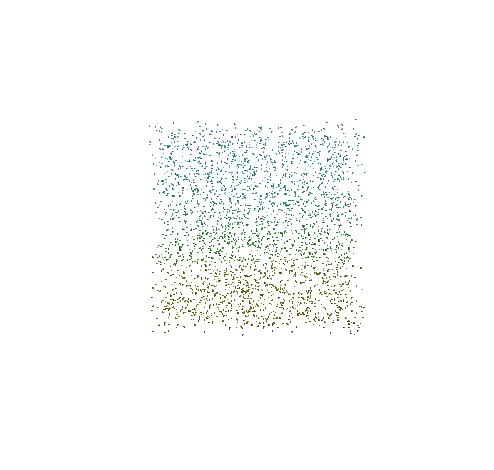

In [853]:
mayavi_plt_pts(x, display=True, focus=data_avg, dist=data_std, trim=False)

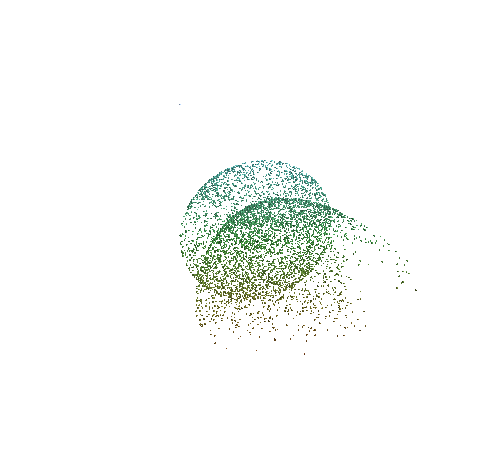

In [850]:
mayavi_plt_pts([init_q_pts,p1p], display=True, focus=data_avg, dist=data_std, trim=False)

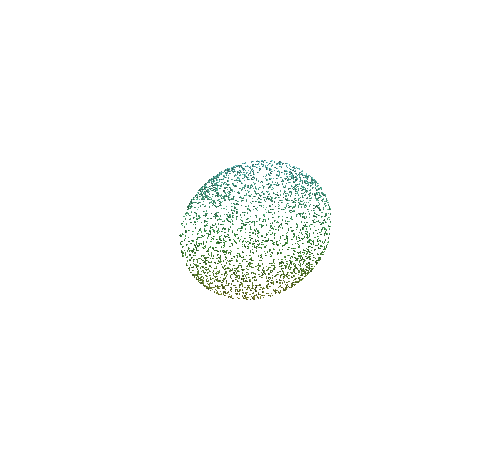

In [847]:
mayavi_plt_pts(init_q_pts, display=True, focus=data_avg, dist=data_std, trim=False)

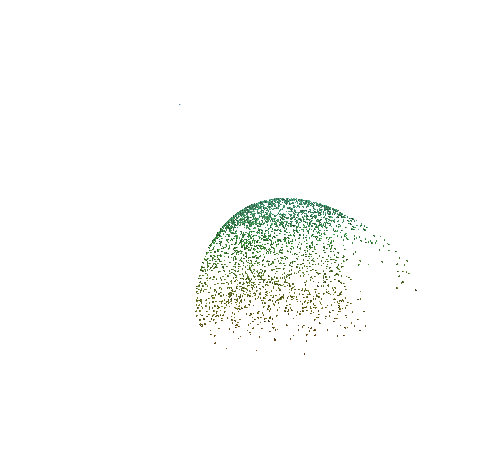

In [848]:
mayavi_plt_pts(p1p, display=True, focus=data_avg, dist=data_std, trim=False)

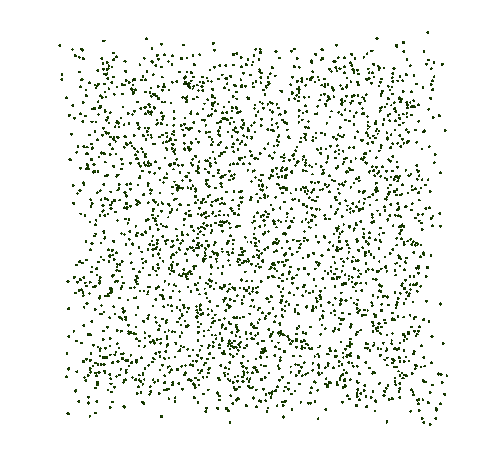

In [844]:
mayavi_plt_pts(tf_pts, pth=os.path.join(project_dir, "tf_qfit_test.png"), display=True, focus=data_avg, dist=data_std, trim=False)

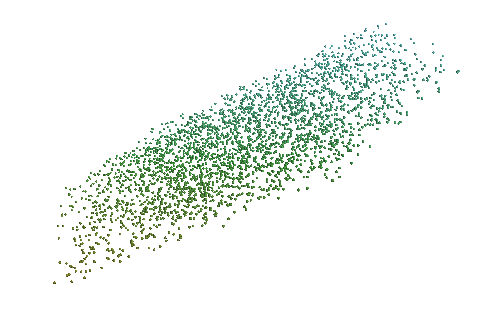

In [734]:
mayavi_plt_pts(np_proj_pts, pth=os.path.join(project_dir, "np_qfit_test.png"), display=True, focus=data_avg, dist=data_std)

In [2008]:
elliptic_q = np.zeros((4,4))
elliptic_q[np.triu_indices(4)] = tfmodel.fast_reasonable_q(p1p)
elliptic_q += elliptic_q.T

[[ 5.00000000e-02  4.29960937e-17 -2.76594487e-17 -4.20086387e-01]
 [ 4.15197513e-17  5.00000000e-02  1.63968458e-17  4.86356378e-01]
 [-2.27212688e-17  2.14013603e-17  5.00000000e-02 -1.03058633e+00]
 [-4.20086387e-01  4.86356378e-01 -1.03058633e+00  1.58600102e+00]]


In [2009]:
elliptic_q

array([[ 1.00000000e-01,  4.29960937e-17, -2.76594487e-17,
        -4.20086387e-01],
       [ 4.29960937e-17,  1.00000000e-01,  1.63968458e-17,
         4.86356378e-01],
       [-2.76594487e-17,  1.63968458e-17,  1.00000000e-01,
        -1.03058633e+00],
       [-4.20086387e-01,  4.86356378e-01, -1.03058633e+00,
         3.17200205e+00]])

In [36]:
elliptic_pts, _ = orthogonal_quadric_projection(x,q,projection_funcs)

In [59]:
import importlib, local_models.plotting_utils
importlib.reload(local_models.plotting_utils)
normalize_view = local_models.plotting_utils.normalize_view

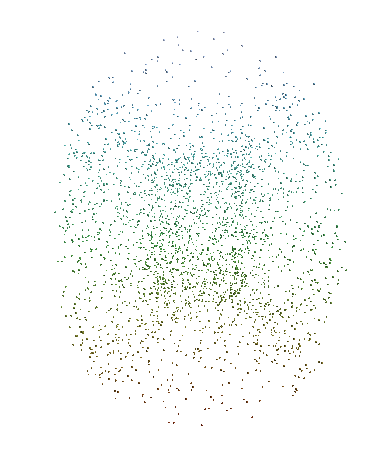

In [108]:
mayavi_plt_pts(elliptic_pts)

In [219]:
local_quadrics = local_models.local_models.LocalModels(TFQuadric(n_epochs=600))
local_quadrics.fit(elliptic_pts)

building!


In [220]:
avg_pt_dist = np.average(local_quadrics.index.query(elliptic_pts, k=2)[0][:,1])

In [221]:
avg_pt_dist

0.09585921798191151

In [222]:
bandwidth = avg_pt_dist*8
lm_kernel = local_models.local_models.TriCubeKernel(bandwidth="knn", k=200)

In [ ]:
try:
    stuff = local_quadrics.transform(elliptic_pts,
        k=lm_kernel.k, weighted=True, kernel=lm_kernel,
        neighbor_beta0s=False, batch_size=int(elliptic_pts.shape[0]/32), return_models=True)
except:
    logger.exception("transformation failed!")

In [226]:
the_losses = list(map(lambda x: x.final_loss, stuff[1]))
the_losses = np.array(the_losses)

In [227]:
the_losses.shape

(3000,)

In [228]:
np.sum(the_losses == np.inf)

4

In [229]:
tuple(map(lambda x: np.sum(the_losses > x), 10.**np.arange(-5,6)))

(2961, 2961, 2961, 2957, 2788, 1980, 1187, 726, 211, 4, 4)

In [230]:
np.sum(the_losses > 0.1), np.sum(the_losses > 1), np.sum(the_losses > 10), np.sum(the_losses > 100)

(2788, 1980, 1187, 726)

In [231]:
np.sum(np.isnan(the_losses))

39

In [232]:
good_final_loss_mask = (~np.isnan(the_losses) & (the_losses < 1))

In [233]:
good_final_loss_models = [stuff[1][i] for i in range(good_final_loss_mask.shape[0]) if good_final_loss_mask[i]]

In [234]:
good_final_loss_models_pts = list(map(lambda y: y.predict(x), good_final_loss_models))

In [235]:
good_final_loss_models_centers = list(map(
    lambda i: good_final_loss_models[i].predict(elliptic_pts[good_final_loss_mask][i:i+1]), 
    range(len(good_final_loss_models))))

In [236]:
np.array(good_final_loss_models_centers).shape

(981, 1, 3)

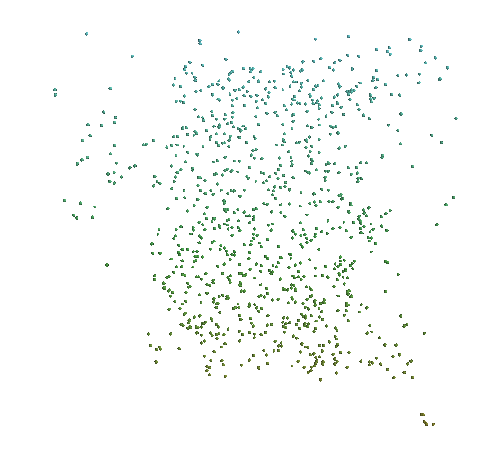

In [237]:
mayavi_plt_pts(np.array(good_final_loss_models_centers)[:,0,:],focus=np.average(elliptic_pts, axis=0),dist=np.std(elliptic_pts, axis=0))

In [238]:
from joblib import Parallel, delayed
plotted = Parallel(n_jobs=8, verbose=10)(delayed(mayavi_plt_pts)(v,w,x,y,z) for v,w,x,y,z in 
    zip(
        good_final_loss_models_pts, 
        [os.path.join(project_dir, "local_surfaces_{:05d}.png".format(i)) for i in range(len(good_final_loss_models_pts))],
        [False]*len(good_final_loss_models_pts),
        [np.average(elliptic_pts, axis=0)]*len(good_final_loss_models_pts),
        [np.std(elliptic_pts, axis=0)]*len(good_final_loss_models_pts)
    )
)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    8.7s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:   10.5s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:   11.5s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:   14.1s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   16.0s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:   18.0s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:   21.2s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:   28.1s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:   32.8s
[Parallel(n_jobs=8)]: Done  97 tasks      | elapsed:   36.1s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:   40.0s
[Parallel(n_jobs=8)]: Done 129 tasks      | elapsed:   50.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:   55.4s
[Parallel(n_jobs=8)]: Done 165 tasks      | elapsed:  1.0min
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  1.1min
[Parallel(

In [114]:
tfmodel = TFQuadric(n_epochs=5000, log_epochs=True, weighted=False, parabolic_constraint=True, learning_rate=0.5)

building!
<tf.Variable 'quadric_regression/quadric_projection/flattened_quadric:0' shape=(10,) dtype=float64_ref>
Tensor("quadric_regression/quadric_projection/sub_1:0", shape=(4, 4), dtype=float64)
Tensor("quadric_regression/quadric_projection/Cast_2:0", shape=(4, 4), dtype=complex128)
Q Tensor("quadric_regression/quadric_projection/Cast_2:0", shape=(4, 4), dtype=complex128)
Tensor("quadric_regression/quadric_projection/transpose_1:0", shape=(3, 3), dtype=complex128)
Tensor("quadric_regression/quadric_projection/matmul_1:0", shape=(?, 3), dtype=complex128)
Tensor("quadric_regression/quadric_projection/matmul_2:0", shape=(1, 3), dtype=complex128)
L,U,UL,UR,BR Tensor("quadric_regression/quadric_projection/SelfAdjointEigV2:0", shape=(3,), dtype=complex128) Tensor("quadric_regression/quadric_projection/SelfAdjointEigV2:1", shape=(3, 3), dtype=complex128) Tensor("quadric_regression/quadric_projection/SelfAdjointEigV2:0", shape=(3,), dtype=complex128) Tensor("quadric_regression/quadric_proj

In [115]:
tfmodel.fit(data)

[4953.36181722 3697.67518591 1453.01588245]
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  8.62858672e-02]
 [ 0.00000000e+00  1.00000000e-04  0.00000000e+00 -2.76417976e-01]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e-04  9.57156127e-01]
 [ 8.62858672e-02 -2.76417976e-01  9.57156127e-01 -1.17627680e+02]]
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  8.62858672e-02]
 [ 0.00000000e+00  1.00000000e-04  0.00000000e+00 -2.76417976e-01]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e-04  9.57156127e-01]
 [ 8.62858672e-02 -2.76417976e-01  9.57156127e-01 -1.17627680e+02]]
[[ 5.06892643e-07  1.73157264e-07 -1.58617964e-08  9.57999101e-05]
 [ 1.73157264e-07  6.38658431e-08  4.60467097e-08  3.27335490e-05]
 [-1.58617964e-08  4.60467097e-08  5.62322414e-07  5.66249166e-03]
 [ 9.57999101e-05  3.27335490e-05  5.66249166e-03 -9.99967925e-01]]
(10,)
(10,)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48


1688
1689
1690
1691
1692
1693
1694
1695
1696
1697
1698
1699
1700
1701
1702
1703
1704
1705
1706
1707
1708
1709
1710
1711
1712
1713
1714
1715
1716
1717
1718
1719
1720
1721
1722
1723
1724
1725
1726
1727
1728
1729
1730
1731
1732
1733
1734
1735
1736
1737
1738
1739
1740
1741
1742
1743
1744
1745
1746
1747
1748
1749
1750
1751
1752
1753
1754
1755
1756
1757
1758
1759
1760
1761
1762
1763
1764
1765
1766
1767
1768
1769
1770
1771
1772
1773
1774
1775
1776
1777
1778
1779
1780
1781
1782
1783
1784
1785
1786
1787
1788
1789
1790
1791
1792
1793
1794
1795
1796
1797
1798
1799
1800
1801
1802
1803
1804
1805
1806
1807
1808
1809
1810
1811
1812
1813
1814
1815
1816
1817
1818
1819
1820
1821
1822
1823
1824
1825
1826
1827
1828
1829
1830
1831
1832
1833
1834
1835
1836
1837
1838
1839
1840
1841
1842
1843
1844
1845
1846
1847
1848
1849
1850
1851
1852
1853
1854
1855
1856
1857
1858
1859
1860
1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887


3327
3328
3329
3330
3331
3332
3333
3334
3335
3336
3337
3338
3339
3340
3341
3342
3343
3344
3345
3346
3347
3348
3349
3350
3351
3352
3353
3354
3355
3356
3357
3358
3359
3360
3361
3362
3363
3364
3365
3366
3367
3368
3369
3370
3371
3372
3373
3374
3375
3376
3377
3378
3379
3380
3381
3382
3383
3384
3385
3386
3387
3388
3389
3390
3391
3392
3393
3394
3395
3396
3397
3398
3399
3400
3401
3402
3403
3404
3405
3406
3407
3408
3409
3410
3411
3412
3413
3414
3415
3416
3417
3418
3419
3420
3421
3422
3423
3424
3425
3426
3427
3428
3429
3430
3431
3432
3433
3434
3435
3436
3437
3438
3439
3440
3441
3442
3443
3444
3445
3446
3447
3448
3449
3450
3451
3452
3453
3454
3455
3456
3457
3458
3459
3460
3461
3462
3463
3464
3465
3466
3467
3468
3469
3470
3471
3472
3473
3474
3475
3476
3477
3478
3479
3480
3481
3482
3483
3484
3485
3486
3487
3488
3489
3490
3491
3492
3493
3494
3495
3496
3497
3498
3499
3500
3501
3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526


4966
4967
4968
4969
4970
4971
4972
4973
4974
4975
4976
4977
4978
4979
4980
4981
4982
4983
4984
4985
4986
4987
4988
4989
4990
4991
4992
4993
4994
4995
4996
4997
4998
4999


TFQuadric(batch_size=None, input_shape=None, learning_rate=0.5, log_epochs=True,
          model=<ml_battery.tensorflow_models.NameSpace object at 0x7f69947a90b8>,
          n_epochs=5000, parabolic_constraint=True, trainable=True,
          weighted=False)

In [ ]:
fitted_q = np.zeros((4,4)); fitted_q[np.triu_indices(4)]=np.copy(tfmodel.init_q)
#fitted_q = np.copy(tfmodel.fitted_qs[-1])
#fitted_q = np.zeros((4,4)); fitted_q[np.triu_indices(4)]=np.copy(tfmodel.coef_)
fitted_q += fitted_q.T
fitted_q[np.diag_indices(4)] /= 2
print(np.linalg.norm(fitted_q))
print(np.round(fitted_q,3))
fitted_q_u = np.linalg.eigh(fitted_q[:3,:3])[1]
fitted_q_e = np.zeros((4,4))
fitted_q_e[3,3] = 1
fitted_q_e[:3,:3] = fitted_q_u
fitted_q_rot = fitted_q_e.T@fitted_q@fitted_q_e
print(np.round(fitted_q_rot,3))
print(np.linalg.norm(fitted_q_rot))

In [ ]:
with tf.Graph().as_default(), tf.Session() as sess:
    test_qs = tf.placeholder(tf.float32, q.shape)
    test_pts = tf.placeholder(tf.float32, x.shape)
    test_qsc = tf.cast(test_qs, tf.complex128 if test_qs.dtype == tf.float64 else tf.complex64)
    test_ptsc = tf.cast(test_pts, tf.complex128 if test_pts.dtype == tf.float64 else tf.complex64)
    projs,dists = tf_ortho_project(test_qsc, test_ptsc, imag_0tol=1e-3)
    loss = tf.reduce_sum(tf.abs(tf.real(dists)),axis=-1)
    res = sess.run((projs,dists,loss,tf.gradients(loss,test_qs)), feed_dict={test_pts: p1p, test_qs: fitted_q})
test_res = orthogonal_quadric_projection(p1p, fitted_q,projection_funcs)
print("total_loss: {} v {}".format(res[1].sum(), test_res[1].sum()))
for i, r in enumerate(test_res):
    try:
        assert np.allclose(r, res[i], atol=1e-4, rtol=1e-4)
    except:
        print(r, res[i], np.abs(r-res[i]))

In [67]:
linear_models = local_models.local_models.LocalModels(local_models.TLS_models.LinearODR_mD(2))
linear_models.fit(data)

In [68]:
avg_pt_dist = np.average(linear_models.index.query(data, k=2)[0][:,1])

In [69]:
avg_pt_dist

1.2836044940342985

In [63]:
random_data_subset = data[np.random.randint(data.shape[0], size=50)]

In [64]:
queried = linear_models.index.query_radius(random_data_subset, r=avg_pt_dist*10)

In [65]:
list(map(lambda x: x.shape, queried))

[(289,),
 (315,),
 (283,),
 (386,),
 (209,),
 (106,),
 (375,),
 (321,),
 (405,),
 (372,),
 (341,),
 (352,),
 (376,),
 (308,),
 (249,),
 (347,),
 (245,),
 (380,),
 (378,),
 (414,),
 (419,),
 (106,),
 (345,),
 (320,),
 (444,),
 (282,),
 (208,),
 (371,),
 (368,),
 (423,),
 (307,),
 (435,),
 (374,),
 (324,),
 (271,),
 (147,),
 (150,),
 (147,),
 (397,),
 (318,),
 (407,),
 (200,),
 (239,),
 (403,),
 (401,),
 (316,),
 (353,),
 (321,),
 (261,),
 (289,)]

In [66]:
kernel = local_models.local_models.TriCubeKernel(bandwidth=avg_pt_dist*10)

In [67]:
linear_params_vecs, linear_params_mean = local_models.linear_projections.transformate_data(data, kernel, linear_models, r=kernel.support_radius())

In [68]:
linear_params_vecs.shape

(58659, 2, 3)

In [83]:
N = int(data.shape[0]/10)
sample_indices = np.random.choice(np.arange(data.shape[0]), size=N)

pth = os.path.join(project_dir, "single_convergence.png")
data_avg = np.average(data, axis=0)
data_std = np.std(data, axis=0)
figure = mayavi.mlab.figure(figure=None, bgcolor=(1,1,1), fgcolor=(0,0,0), engine=None, size=(1000, 500))
data_nodes = plt_data(figure, linear_params_mean[sample_indices], data_std)
normals = np.cross(*np.rollaxis(linear_params_vecs[sample_indices],1))
#normal_vecs = plt_normals(figure, normals, linear_params_mean[sample_indices], data_std)
#neg_normal_vecs = plt_normals(figure, -normals, linear_params_mean[sample_indices], data_std)
normalize_view(figure, data_avg, data_std, azimuth=40, elevation=80)
mayavi.mlab.savefig(pth, magnification=2)
mayavi.mlab.close(figure)

(-0.5, 1999.5, 999.5, -0.5)

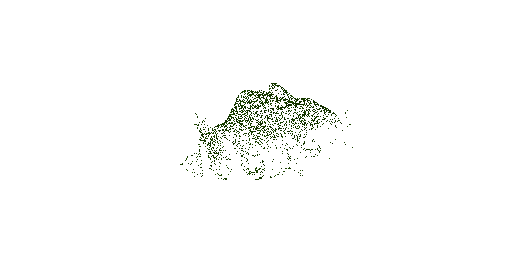

In [105]:
imshow(pth)
plt.axis("off")

In [84]:
global_linear_model = local_models.TLS_models.LinearODR_mD(2)
global_linear_model.fit(data)

In [87]:
global_linear_model.coef_
global_params_vecs = global_linear_model.coef_.reshape(2,-1)
global_params_mean = global_linear_model.intercept_
global_normal = np.cross(*global_params_vecs)

In [94]:
basis_changer = np.concatenate((global_params_vecs, global_normal.reshape(1,-1)),axis=0).T
basis_changer = np.linalg.inv(basis_changer)

In [95]:
bases_changed = np.einsum('ij,kj->ki', basis_changer, data-global_params_mean)

In [98]:
x,y,z = bases_changed.T

(-187.9690848273605,
 160.5978956286218,
 -131.18478754473625,
 174.82998666860883)

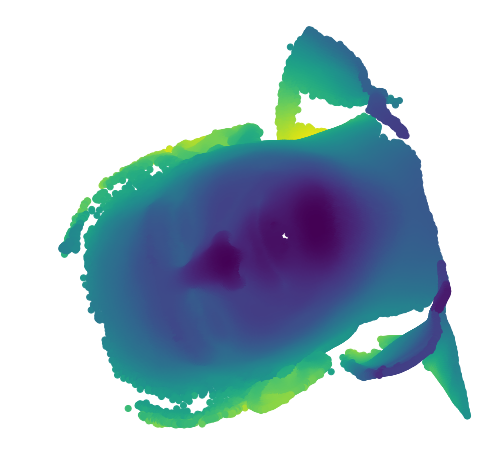

In [106]:
plt.scatter(x,y,c=z)
plt.axis("off")